<a href="https://colab.research.google.com/github/AntikGhalt/predicting_bankruptcy_AIDA/blob/main/AIDA_2_TEST2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### COLAB DRIVE

---



In [ ]:
#@title RESET AND FILES NAME
%reset -f
#path data export
model_folder = "model_test/"

# list your files in the exact order you want their rows to appear
file_names = [
    "Aida_Export_TESTin2_0_1374.xlsx",
    "Aida_Export_TESTout_100001_101000.xlsx",
]

test_files = [
    "Aida_Export_testD2_001_200.xlsx",
    "Aida_Export_testD2_201_400.xlsx",
    "Aida_Export_testD2_401_600.xlsx",
    "Aida_Export_testD2_601_800.xlsx",
    "Aida_Export_testD2_801_1000.xlsx",
    "Aida_Export_testD2_1001_1200.xlsx",
    "Aida_Export_testD2_1201_1374.xlsx",
    "Aida_Export_testD_100001_100100.xlsx",
    "Aida_Export_testD_100101_100200.xlsx",
    "Aida_Export_testD_100201_100400.xlsx",
    "Aida_Export_testD_100401_100600.xlsx",
    "Aida_Export_testD_100601_100800.xlsx",
    "Aida_Export_testD_100801_101000.xlsx"
]

In [ ]:
path_data = "/content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/" + model_folder
path_MODEL = "/content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/output/" + model_folder

In [ ]:
!pip install pandas
#!pip install scikit-learn
#!pip install optuna


import pandas as pd
import os
import numpy as np
import re
import gc
from IPython.display import clear_output
from google.colab import data_table
import matplotlib.pyplot as plt
import seaborn as sns
"""
def safe_literal_eval(x):
    # If x is a list or numpy array and empty, return an empty list
    if isinstance(x, (list, np.ndarray)) and len(x) == 0:
        return []
    # For scalar values, check if x is NaN
    if not isinstance(x, (list, np.ndarray)) and pd.isna(x):
        return []

    # Otherwise, convert to string and strip any whitespace
    x = str(x).strip()

    try:
        return ast.literal_eval(x)
    except Exception:
        return x
"""
clear_output()

## Building dataframe

---



### DATA MANIPULATION

---




In [ ]:
#@title FILES ≥ 15 (with per–chunk date/year fixing · v2)

import re, gc, numpy as np, pandas as pd
date_pattern = re.compile(r'(year|date)$', re.IGNORECASE)

df_list = []
for fn in file_names:                                # ← assumes path_data + file_names
    print(f"Processing file: {fn}")
    tmp = pd.read_excel(
        path_data + fn,
        sheet_name="Results",
        na_values=["n.a."],
        keep_default_na=True
    )
    # normalise enterprise key
    tmp["Tax code number"] = tmp["Tax code number"].astype("Int64")

    # ───────────────────────────────────────────────────────────────────────
    # fix every *…year / …date* column in this chunk
    # ───────────────────────────────────────────────────────────────────────
    for col in tmp.columns:
        if not date_pattern.search(col):
            continue

        raw = tmp[col]
        ser = pd.to_numeric(raw, errors="coerce")        # numeric if possible

        # a) discard values outside a safe Excel-serial window  (-10 000 … 100 000)
        safe = ser.between(-10_000, 100_000) & ser.notna()
        dt   = pd.Series(pd.NaT, index=ser.index)        # pre-allocate with NaT

        if safe.any():                                   # convert *only* safe values
            dt.loc[safe] = pd.to_datetime(
                ser.loc[safe].astype("int64"),           # int64 avoids float weirdness
                unit="D",
                origin="1899-12-30",
                errors="coerce"
            )

        # b) remaining non-null → try string parse (day-first)
        mask_str = dt.isna() & raw.notna()
        if mask_str.any():
            dt.loc[mask_str] = pd.to_datetime(
                raw[mask_str],
                dayfirst=True,
                errors="coerce"
            )

        tmp[col] = dt
        print(f"  {col}: parsed {dt.notna().sum():,}/{raw.notna().sum():,} values")

    df_list.append(tmp)
    del tmp
    gc.collect()

# concatenate all chunks
df_start = pd.concat(df_list, ignore_index=True)
print("Final shape:", df_start.shape)


Processing file: Aida_Export_TESTin2_0_1374.xlsx
  Incorporation year: parsed 1,368/1,368 values
  Last accounting closing date: parsed 1,374/1,374 values
Processing file: Aida_Export_TESTout_100001_101000.xlsx
  Incorporation year: parsed 1,000/1,000 values
  Last accounting closing date: parsed 1,000/1,000 values
Final shape: (4281, 16)


In [ ]:
#@title Events Manipulation

# 2) Build your 'master' enterprises (one row per tax code)
master = (
    df_start[df_start['Tax code number'].notna()]
      .drop_duplicates(subset='Tax code number', keep='first')
)

# 3) Prepare the events table
events = (
    df_start[['Tax code number',
        'Procedure/cessazione',
        'Date of open procedure/cessazione',
        'Date of closure procedure']]
    .copy()
)
# fill down the tax‐code so every event row has its enterprise key
events['Tax code number'] = events['Tax code number'].ffill()

# keep only real events
events = events[events['Procedure/cessazione'].notna()].rename(columns={
    'Procedure/cessazione':        'Procedure',
    'Date of open procedure/cessazione': 'open_date',
    'Date of closure procedure':   'close_date'
})

# parse dates
events['open_date']  = pd.to_datetime(events['open_date'],  dayfirst=True, errors='coerce')
events['close_date'] = pd.to_datetime(events['close_date'], dayfirst=True, errors='coerce')

# 4) Sort & number each event per enterprise
events = (events
          .sort_values(['Tax code number', 'open_date'], ascending=[True, False]))
events['event_idx'] = events.groupby('Tax code number').cumcount()
events['event_idx'] = -events['event_idx']

# 5) Pivot to wide with unstack
df_e = events.set_index(['Tax code number','event_idx'])[['Procedure','open_date','close_date']]
df_un = df_e.unstack('event_idx')  # shape: index=tax codes, columns=(field, idx)
#5.1 order of tuples
field_order = ['Procedure','open_date','close_date']
idx_order   = sorted(df_un.columns.levels[1], reverse=True)

ordered_tuples = [
    (field, idx)
    for field in field_order
    for idx   in idx_order
    if (field, idx) in df_un.columns
]

df_un = df_un.reindex(columns=pd.MultiIndex.from_tuples(ordered_tuples))
# 6) Flatten the MultiIndex columns
df_un.columns = [
    (f"Event {i}"                 if field=='Procedure' else
     f"Date of open Event {i}"   if field=='open_date' else
     f"Date of closure Event {i}")
    for field, i in df_un.columns
]
df_un = df_un.reset_index()  # bring back Tax code number as a column

# 7) Merge back onto master (preserves your enterprise order)
final_df = (master
            .merge(df_un, on='Tax code number', how='left', sort=False)
            .reset_index(drop=True)
           )

#print(f"Enterprises: {len(master)}, rows in final_df: {len(final_df)}")
#final_df.head()

final_df = final_df.drop(columns=[
    'Procedure/cessazione',
    'Date of open procedure/cessazione',
    'Date of closure procedure'
])

In [ ]:
#@title Appending
# 1) Treat only "n.a." as missing when reading
read_kwargs = dict(
    sheet_name="Results",
    index_col=None,
    na_values=["n.a."],
    keep_default_na=True
)

# 2) Read & stack all the new data end-to-end
df_list = []
for fn in test_files:
    tmp = pd.read_excel(path_data + fn, **read_kwargs)
    tmp['Tax code number'] = tmp['Tax code number'].astype('Int64')
    df_list.append(tmp)

In [ ]:
#@title Balance sheet MANIPULATION - stacking and Fix Duplicate Column Names before mergingh

import re

# 1) Stack all new files into one DataFrame
all_new = pd.concat(df_list, ignore_index=True)


# Function to extract base name (without year) from column name
def get_base_name(col_name):
    """Extract the base variable name without the year, handling .1 .2 suffixes"""
    # First, remove any .1, .2, etc. suffix if present
    suffix_pattern = re.compile(r'\.\d+$')
    col_name_cleaned = suffix_pattern.sub('', col_name)

    # Now look for year at the end (after potential newlines)
    year_pattern = re.compile(r'(20\d{2})$', re.MULTILINE)
    if year_pattern.search(col_name_cleaned):
        # Remove the year to get base name
        base = year_pattern.sub('', col_name_cleaned).strip()
        return base
    return None

# Process all_new dataframe to add group prefixes
print("Processing all_new dataframe to fix duplicate column names...")
print(f"Original shape: {all_new.shape}")

# Get all columns
columns = list(all_new.columns)
new_columns = []
group_counter = 1
seen_groups = {}  # Track which base names we've seen and their group numbers
current_base = None
current_group = None

# Process columns in order
for i, col in enumerate(columns):
    base_name = get_base_name(col)

    if base_name is None:
        # Not a year column, keep as is
        new_columns.append(col)
    else:
        # Check if this is a new group
        if base_name != current_base:
            # New group detected
            if base_name in seen_groups:
                # We've seen this base name before, increment group number
                current_group = max(seen_groups[base_name]) + 1
                seen_groups[base_name].append(current_group)
            else:
                # First time seeing this base name
                current_group = group_counter
                seen_groups[base_name] = [current_group]
                group_counter += 1

            current_base = base_name

        # Add prefix to column name
        new_col_name = f"{current_group:04d}_{col}"
        new_columns.append(new_col_name)

# Apply new column names
all_new.columns = new_columns

print(f"\nTotal groups created: {group_counter - 1}")
print(f"Columns renamed: {len([old for old, new in zip(columns, new_columns) if old != new])}")

# Show examples of renamed columns
print("\nExamples of renamed columns:")
year_pattern = re.compile(r'(20\d{2})$', re.MULTILINE)
renamed_examples = [(old, new) for old, new in zip(columns, new_columns)
                    if old != new and year_pattern.search(old)][:10]

for old, new in renamed_examples:
    # Show in readable format
    old_display = old.replace('\n', '\\n')
    new_display = new.replace('\n', '\\n')
    print(f"  {old_display} -> {new_display}")

# Verify no duplicates remain
duplicate_cols = all_new.columns[all_new.columns.duplicated()].tolist()
if duplicate_cols:
    print(f"\n⚠️ Warning: Still have {len(duplicate_cols)} duplicate columns!")
    print(f"Duplicates: {duplicate_cols[:5]}")
else:
    print("\n✅ Success: No duplicate columns remaining!")

# Show column name patterns
print("\nColumn name patterns (first few groups):")
for base_name, groups in list(seen_groups.items())[:5]:
    base_display = base_name.split('\n')[0][:50]  # First line, max 50 chars
    print(f"  '{base_display}...' appears in groups: {groups}")

# Test the function
test_cases = [
    "Additions in progress and advances\nth EUR\n2023",
    "Additions in progress and advances\nth EUR\n2023.1",
    "Additions in progress and advances\nth EUR\n2023.2",
    "Company name",
    "Tax code number"
]

print("Testing improved get_base_name function:")
for test in test_cases:
    result = get_base_name(test)
    test_display = test.replace('\n', '\\n')
    print(f"  '{test_display}' -> {repr(result)}")

Processing all_new dataframe to fix duplicate column names...
Original shape: (2374, 4243)

Total groups created: 365
Columns renamed: 4240

Examples of renamed columns:
  Revenues from sales and services\nth EUR\n2023 -> 0001_Revenues from sales and services\nth EUR\n2023
  Revenues from sales and services\nth EUR\n2022 -> 0001_Revenues from sales and services\nth EUR\n2022
  Revenues from sales and services\nth EUR\n2021 -> 0001_Revenues from sales and services\nth EUR\n2021
  Revenues from sales and services\nth EUR\n2020 -> 0001_Revenues from sales and services\nth EUR\n2020
  Revenues from sales and services\nth EUR\n2019 -> 0001_Revenues from sales and services\nth EUR\n2019
  Revenues from sales and services\nth EUR\n2018 -> 0001_Revenues from sales and services\nth EUR\n2018
  Revenues from sales and services\nth EUR\n2017 -> 0001_Revenues from sales and services\nth EUR\n2017
  Revenues from sales and services\nth EUR\n2016 -> 0001_Revenues from sales and services\nth EUR\n201

In [ ]:
#@title Merging

# 2) Ensure the key is the same type
all_new['Tax code number'] = all_new['Tax code number'].astype('Int64')

# 3) Perform a 1:1 left-join of your master with the new data,
df = final_df.merge(
    all_new,
    on='Tax code number',
    how='left',
    validate='one_to_one'
)
# Fix duplicate column names if they exist
if 'Company name_x' in df.columns and 'Company name_y' in df.columns:
    # Keep the one from final_df (left side) and drop the duplicate
    df['Company name'] = df['Company name_x']
    df = df.drop(columns=['Company name_x', 'Company name_y'])
    print("Fixed duplicate Company name columns")

print(df.shape)  # rows == final_df.rows; columns == union of both sets of variables


Fixed duplicate Company name columns
(2374, 4272)


In [ ]:
#@title visualize big database

# Show *every* column
pd.set_option('display.max_columns', 1000)

# (Optionally widen your display so lines don’t wrap too crazily)
pd.set_option('display.width', 20)
pd.set_option('display.max_colwidth', 50)

# Now when you do…
#df

#print(final_df.iloc[:, :10])
#df.iloc[:30, :200]
#df.iloc[1000:1030, :200]

df.iloc[985:1015, :200]

Unnamed: 0_x  \
985          986.0   
986          987.0   
987          988.0   
988          989.0   
989          990.0   
990          991.0   
991          992.0   
992          993.0   
993          994.0   
994          995.0   
995          996.0   
996          997.0   
997          998.0   
998          999.0   
999         1000.0   
1000        1001.0   
1001        1002.0   
1002        1003.0   
1003        1004.0   
1004        1005.0   
1005        1006.0   
1006        1007.0   
1007        1008.0   
1008        1009.0   
1009        1010.0   
1010        1011.0   
1011        1012.0   
1012        1013.0   
1013        1014.0   
1014        1015.0   

      Tax code number  \
985        9968750019   
986        2704210737   
987       14092331009   
988        3304940129   
989        2470960036   
990        2957110790   
991        1788460184   
992        1661000768   
993        4072960265   
994        1283450458   
995        1470290881   
996        6344390486   
997        4841270962   
998        1266590197   
999       12857871003   
1000      10144890968   
1001       2182360566   
1002       4439210826   
1003       2279990978   
1004       4659390282   
1005       7713980725   
1006       7251580721   
1007       9611220964   
1008       3950640288   
1009       3475700104   
1010       5341230877   
1011       1598820890   
1012       3439910138   
1013       1268070321   
1014       2462000031   

      Registered office address - Postal code  \
985                                   10147.0   
986                                   74015.0   
987                                     177.0   
988                                   21100.0   
989                                   28883.0   
990                                   88812.0   
991                                   27100.0   
992                                   85100.0   
993                                   31044.0   
994                                   19020.0   
995                                   97100.0   
996                                   50132.0   
997                                   20161.0   
998                                   26013.0   
999                                     191.0   
1000                                  20125.0   
1001                                   1033.0   
1002                                  90141.0   
1003                                  59100.0   
1004                                  35100.0   
1005                                  70022.0   
1006                                  70026.0   
1007                                  20162.0   
1008                                  35010.0   
1009                                  16121.0   
1010                                  95024.0   
1011                                  96010.0   
1012                                  22066.0   
1013                                  34139.0   
1014                                  28831.0   

      Registered office address - Longitude  \
985                                7.669836   
986                               17.334345   
987                                     NaN   
988                                8.816618   
989                                8.431464   
990                              -10.189901   
991                                9.156591   
992                               15.806087   
993                               12.047088   
994                                9.866257   
995                               14.684561   
996                               11.272202   
997                                9.174967   
998                                9.665222   
999                               12.493132   
1000                               9.224894   
1001                              12.412092   
1002                              13.346784   
1003                              11.079928   
1004                              11.877567   
1005                              16.556

In [ ]:
print(df.shape)

(2374, 4272)


In [ ]:
#@title LIST MISSING VARIABLES

# 1) Count columns that are 100% missing
all_nan = df.columns[df.isna().all()]
print(f"Columns with all NaN: {len(all_nan)}")

# 2) Drop them
df.drop(columns=all_nan, inplace=True)

# 3) Show the list of dropped columns
print("Dropped columns:")
for col in all_nan:
    print(f" - {col}")


Columns with all NaN: 917
Dropped columns:
 - Date of closure Event -4
 - Date of closure Event -5
 - 0081_Amounts due for advance taxation
th EUR
2023
 - 0081_Amounts due for advance taxation
th EUR
2022
 - 0081_Amounts due for advance taxation
th EUR
2021
 - 0081_Amounts due for advance taxation
th EUR
2020
 - 0081_Amounts due for advance taxation
th EUR
2019
 - 0081_Amounts due for advance taxation
th EUR
2018
 - 0081_Amounts due for advance taxation
th EUR
2017
 - 0081_Amounts due for advance taxation
th EUR
2016
 - 0081_Amounts due for advance taxation
th EUR
2015
 - 0081_Amounts due for advance taxation
th EUR
2014
 - 0109_GROUP consolidation reserve
th EUR
2023
 - 0109_GROUP consolidation reserve
th EUR
2022
 - 0109_GROUP consolidation reserve
th EUR
2021
 - 0109_GROUP consolidation reserve
th EUR
2020
 - 0109_GROUP consolidation reserve
th EUR
2019
 - 0109_GROUP consolidation reserve
th EUR
2018
 - 0109_GROUP consolidation reserve
th EUR
2017
 - 0109_GROUP consolidation reserve

In [ ]:
#@title RANK OF MISSING in NON-MISSING VARIABLES

# 4) Compute missing counts for the rest, sort descending
missing_counts = df.isna().sum().sort_values(ascending=False)

# Ensure pandas will print all rows
pd.set_option('display.max_rows', None)

print("\nMissing‐value counts for remaining columns (desc):")
print(missing_counts)



Missing‐value counts for remaining columns (desc):
0365_Monthly - Trading volume - December\n2018                                                                                             2373
0365_Monthly - Trading volume - December\n2019                                                                                             2373
0365_Monthly - Trading volume - December\n2015                                                                                             2373
0365_Monthly - Trading volume - December\n2016                                                                                             2373
0365_Monthly - Trading volume - December\n2022                                                                                             2373
0365_Monthly - Trading volume - December\n2021                                                                                             2373
0365_Monthly - Trading volume - December\n2020                                      

In [ ]:
#@title SAVE PROCESSED DATASET (Wide Format)
import pickle

# Save the processed wide format dataset
save_path = path_data + 'processed_df_wide.pkl'
df.to_pickle(save_path)
print(f"✅ Saved processed dataset to: {save_path}")
print(f"Shape: {df.shape}, Size: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

✅ Saved processed dataset to: /content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/model_test/processed_df_wide.pkl
Shape: (2374, 3355), Size: 67.8 MB


### (#) open dataset created

In [ ]:
#@title LOAD PROCESSED DATASET (Wide Format)
import pickle
import pandas as pd
import re

# Load the pre-processed dataset
load_path = path_data + 'processed_df_wide.pkl'

try:
    df = pd.read_pickle(load_path)
    print(f"✅ Loaded processed dataset from: {load_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns with 'date'/'year': {len([c for c in df.columns if re.search(r'(year|date)$', c, re.IGNORECASE)])}")

    # Quick validation that dates are still datetime objects
    date_cols = [c for c in df.columns if re.search(r'(year|date)$', c, re.IGNORECASE)]
    if date_cols:
        sample_col = date_cols[0]
        print(f"Date dtype check - {sample_col}: {df[sample_col].dtype}")

    # Check event columns
    event_cols = [c for c in df.columns if c.startswith('Event ')]
    print(f"Event columns found: {len(event_cols)}")

except FileNotFoundError:
    print("❌ Processed file not found. Run the full import process first.")
except Exception as e:
    print(f"❌ Error loading processed file: {e}")

✅ Loaded processed dataset from: /content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/model_test/processed_df_wide.pkl
Shape: (2000, 3517)
Columns with 'date'/'year': 2
Date dtype check - Incorporation year: datetime64[ns]
Event columns found: 7


### Reshape, dummy

---



In [ ]:
#@title Bankruptcy dummy

# Create bankruptcy dummy and date variables
df['Bankruptcy_dummy'] = 0
df['Bankruptcy_dummy_date'] = pd.NaT

# Find all event columns
event_cols = [c for c in df.columns if c.startswith('Event ') and not c.startswith('Date of')]

print(f"Checking {len(event_cols)} event columns for bankruptcy...")

# For each row, check if any event contains "Bankruptcy"
bankruptcy_count = 0

for idx, row in df.iterrows():
    for event_col in event_cols:
        event_value = row[event_col]

        # Check if this event is exactly "Bankruptcy" (case sensitive)
        if pd.notna(event_value) and event_value == 'Bankruptcy':
            # Set the dummy to 1
            df.loc[idx, 'Bankruptcy_dummy'] = 1

            # Extract the event number from column name (e.g., "Event -2" -> "-2")
            event_num = event_col.replace('Event ', '')

            # Find the corresponding date column
            date_col = f'Date of open Event {event_num}'

            # If the date column exists and has a value, store it
            if date_col in df.columns and pd.notna(row[date_col]):
                df.loc[idx, 'Bankruptcy_dummy_date'] = pd.to_datetime(row[date_col])
                bankruptcy_count += 1
                break  # Stop after finding the first bankruptcy event

# Convert date column to datetime type
df['Bankruptcy_dummy_date'] = pd.to_datetime(df['Bankruptcy_dummy_date'])

# Display summary
print(f"\nTotal enterprises with Bankruptcy event: {df['Bankruptcy_dummy'].sum()}")
print(f"Enterprises with valid bankruptcy dates: {bankruptcy_count}")

# Show distribution
print("\nBankruptcy_dummy distribution:")
print(df['Bankruptcy_dummy'].value_counts())

# Show sample of enterprises with bankruptcy
bankrupt_sample = df[df['Bankruptcy_dummy'] == 1][['Tax code number', 'Company name', 'Bankruptcy_dummy', 'Bankruptcy_dummy_date']].head(10)
print("\nSample of enterprises with bankruptcy:")
display(bankrupt_sample)

Checking 6 event columns for bankruptcy...

Total enterprises with Bankruptcy event: 1374
Enterprises with valid bankruptcy dates: 1373

Bankruptcy_dummy distribution:
Bankruptcy_dummy
1    1374
0    1000
Name: count, dtype: int64

Sample of enterprises with bankruptcy:


Tax code number  \
0        647460286   
1       4261290821   
2       2229420415   
3       1614500799   
4       3074840160   
5       3725790137   
6       1697130464   
7      13116741003   
8      13069551003   
9      13778081003   

                                        Company name  \
0                                       VIMET S.P.A.   
1                        FENICE DISTRIBUZIONE S.R.L.   
2                                  BENELLI Q. J. SRL   
3  LA NUOVA NAVE SOCIETA' A RESPONSABILITA' LIMIT...   
4                             ONGIS METAL FER S.P.A.   
5                      NUOVA REX SUPERMERCATI S.R.L.   
6                    PERINI NAVI SOCIETA' PER AZIONI   
7                                     CARFUEL S.R.L.   
8                                 FUEL ENERGY S.R.L.   
9                          COMUNICARE INSIEME S.R.L.   

   Bankruptcy_dummy  \
0                 1   
1                 1   
2                 1   
3                 1   
4                 1   
5                 1   
6                 1   
7                 1   
8                 1   
9                 1   

  Bankruptcy_dummy_date  
0            2017-03-03  
1            2017-05-15  
2            2016-07-12  
3            2021-10-12  
4            2018-03-16  
5            2021-07-22  
6            2021-01-29  
7            2018-05-08  
8            2017-12-05  
9            2022-01-10

In [ ]:
#@title Reshape Long

# Starting from `df` which has Bankruptcy_dummy and Bankruptcy_dummy_date

# 1. First, identify columns with years
year_pattern = re.compile(r'(20\d{2})(?:\.\d+)?$', re.MULTILINE)  # Matches year with optional .1, .2 suffix
wide_cols = [col for col in df.columns if year_pattern.search(col)]
id_cols = [c for c in df.columns if c not in wide_cols]

print(f"Found {len(wide_cols)} columns with years")
print(f"Number of ID columns: {len(id_cols)}")
print(f"Total enterprises: {len(df)}")

# 2. Create a function to extract variable name and year
def parse_column_name(col_name):
    """Extract clean variable name and year from column"""
    year_match = year_pattern.search(col_name)
    if year_match:
        year = int(year_match.group(1))
        # Get variable name (first line before \n)
        var_name = col_name.split('\n')[0].strip()
        return var_name, year
    return None, None

# 3. Get unique years and variables
years = set()
variables = set()
col_mapping = {}  # Maps (variable, year) to original column name

for col in wide_cols:
    var_name, year = parse_column_name(col)
    if var_name and year:
        years.add(year)
        variables.add(var_name)
        col_mapping[(var_name, year)] = col

years = sorted(years)
variables = sorted(variables)

print(f"\nYears found: {min(years)} to {max(years)} (Total: {len(years)} years)")
print(f"Number of unique variables: {len(variables)}")
print(f"Expected max rows (if no bankruptcy): {len(df) * len(years):,}")

# 4. Process in chunks to save memory
chunk_size = 100  # Process 100 enterprises at a time
long_chunks = []
total_rows_created = 0
enterprises_truncated = 0

print("\nProcessing in chunks to save memory...")

for chunk_start in range(0, len(df), chunk_size):
    chunk_end = min(chunk_start + chunk_size, len(df))

    # Get chunk of enterprises
    df_chunk = df.iloc[chunk_start:chunk_end]

    # Create list to store long format data for this chunk
    chunk_data = []

    for _, row in df_chunk.iterrows():
        tax_code = row['Tax code number']

        # Get bankruptcy year if exists
        bankruptcy_year = None
        if row['Bankruptcy_dummy'] == 1 and pd.notna(row['Bankruptcy_dummy_date']):
            bankruptcy_year = row['Bankruptcy_dummy_date'].year
            enterprises_truncated += 1

        # For each year
        rows_for_enterprise = 0
        for year in years:
            # Skip years after bankruptcy
            if bankruptcy_year and year > bankruptcy_year:
                continue

            # Create row for this enterprise-year
            long_row = {}

            # Add ID columns (including Bankruptcy_dummy and Bankruptcy_dummy_date)
            for id_col in id_cols:
                long_row[id_col] = row[id_col]

            # Add year
            long_row['Year'] = year

            # Add variable values for this year
            for var_name in variables:
                col_key = (var_name, year)
                if col_key in col_mapping:
                    orig_col = col_mapping[col_key]
                    if orig_col in row.index:
                        long_row[var_name] = row[orig_col]
                    else:
                        long_row[var_name] = np.nan
                else:
                    long_row[var_name] = np.nan

            chunk_data.append(long_row)
            rows_for_enterprise += 1
            total_rows_created += 1

    # Convert chunk to dataframe
    chunk_long = pd.DataFrame(chunk_data)
    long_chunks.append(chunk_long)

    # Progress update
    if (chunk_end % 500 == 0) or (chunk_end == len(df)):
        print(f"  Processed {chunk_end}/{len(df)} enterprises... Total rows created: {total_rows_created:,}")

    # Clean up memory
    del chunk_data
    gc.collect()

# 5. Combine all chunks
print("\nCombining chunks...")
long_df = pd.concat(long_chunks, ignore_index=True)

# Clean up
del long_chunks
gc.collect()

# 6. Add derived columns
print("\nAdding derived columns...")

# Create NameYear using the actual Company name column
if 'Company name' in long_df.columns:
    long_df['NameYear'] = long_df['Company name'].astype(str) + ' ' + long_df['Year'].astype(str)
    print("Using 'Company name' column for NameYear")
else:
    print("Warning: 'Company name' column not found!")

# Create KeyYear using Tax code number + Year
long_df['KeyYear'] = long_df['Tax code number'].astype(str) + '_' + long_df['Year'].astype(str)

# 7. Sort the data
long_df = long_df.sort_values(['Tax code number', 'Year']).reset_index(drop=True)

# 8. Display summary
print(f"\nFinal shape: {long_df.shape}")
print(f"Memory usage: {long_df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"Unique enterprises: {long_df['Tax code number'].nunique()}")
print(f"Years covered: {long_df['Year'].min()} to {long_df['Year'].max()}")
print(f"Enterprises truncated due to bankruptcy: {enterprises_truncated}")

# Check observation count per enterprise
obs_per_enterprise = long_df.groupby('Tax code number').size()
print(f"\nObservations per enterprise:")
print(obs_per_enterprise.value_counts().sort_index())

# 9. Save to file
print("\nSaving to pickle file...")
long_df.to_pickle(path_data + 'long_format_data.pkl')
print("Saved successfully!")

# 10. Show sample
print("\nSample of reshaped data (first 20 rows):")
display(long_df.head(20))

# Show a company with bankruptcy
bankrupt_companies = long_df[long_df['Bankruptcy_dummy'] == 1]['Tax code number'].unique()
if len(bankrupt_companies) > 0:
    sample_bankrupt = bankrupt_companies[0]
    print(f"\nSample bankrupt company {sample_bankrupt}:")
    display(long_df[long_df['Tax code number'] == sample_bankrupt])

# Show columns
print("\nColumns in long format (first 50):")
for i, col in enumerate(long_df.columns[:50]):
    print(f"  {i+1}. {col}")

Found 3325 columns with years
Number of ID columns: 32
Total enterprises: 2374

Years found: 2014 to 2023 (Total: 10 years)
Number of unique variables: 353
Expected max rows (if no bankruptcy): 23,740

Processing in chunks to save memory...
  Processed 500/2374 enterprises... Total rows created: 3,272
  Processed 1000/2374 enterprises... Total rows created: 6,644
  Processed 1500/2374 enterprises... Total rows created: 10,355
  Processed 2000/2374 enterprises... Total rows created: 15,355
  Processed 2374/2374 enterprises... Total rows created: 19,095

Combining chunks...

Adding derived columns...
Using 'Company name' column for NameYear

Final shape: (19095, 388)
Memory usage: 0.07 GB
Unique enterprises: 2364
Years covered: 2014 to 2023
Enterprises truncated due to bankruptcy: 1373

Observations per enterprise:
1        2
3       12
4       89
5      215
6      334
7      245
8      304
9      155
10    1008
Name: count, dtype: int64

Saving to pickle file...
Saved successfully!

Sam

Unnamed: 0_x  \
0          925.0   
1          925.0   
2          925.0   
3          925.0   
4          925.0   
5          925.0   
6          925.0   
7          925.0   
8          925.0   
9          925.0   
10         328.0   
11         328.0   
12         328.0   
13         328.0   
14         328.0   
15         328.0   
16         328.0   
17         328.0   
18         328.0   
19         328.0   

    Tax code number  \
0          27110881   
1          27110881   
2          27110881   
3          27110881   
4          27110881   
5          27110881   
6          27110881   
7          27110881   
8          27110881   
9          27110881   
10         65920779   
11         65920779   
12         65920779   
13         65920779   
14         65920779   
15         65920779   
16         65920779   
17         65920779   
18         65920779   
19         65920779   

    Registered office address - Postal code  \
0                                   97100.0   
1                                   97100.0   
2                                   97100.0   
3                                   97100.0   
4                                   97100.0   
5                                   97100.0   
6                                   97100.0   
7                                   97100.0   
8                                   97100.0   
9                                   97100.0   
10                                  75100.0   
11                                  75100.0   
12                                  75100.0   
13                                  75100.0   
14                                  75100.0   
15                                  75100.0   
16                                  75100.0   
17                                  75100.0   
18                                  75100.0   
19                                  75100.0   

    Registered office address - Longitude  \
0                               14.744959   
1                               14.744959   
2                               14.744959   
3                               14.744959   
4                               14.744959   
5                               14.744959   
6                               14.744959   
7                               14.744959   
8                               14.744959   
9                               14.744959   
10                              16.606129   
11                              16.606129   
12                              16.606129   
13                              16.606129   
14                              16.606129   
15                              16.606129   
16                              16.606129   
17                              16.606129   
18                              16.606129   
19                              16.606129   

    Registered office address - Latitude  \
0                              36.925594   
1                              36.925594   
2                              36.925594   
3                              36.925594   
4                              36.925594   
5                              36.925594   
6                              36.925594   
7                              36.925594   
8                              36.925594   
9                              36.925594   
10                             40.668660   
11                             40.668660   
12                             40.668660   
13                             40.668660   
14                             40.668660   
15                             40.668660   
16                             40.668660   
17                             40.668660   
18                             40.668660   
19                             40.668660   

    Trading address - Postal code  \
0                         97100.0   
1                         97100.0   
2                         97100.0   
3                         97100.0   
4                         97100.0   
5                 


Sample bankrupt company 151040623:


Unnamed: 0_x  \
150        1110.0   
151        1110.0   
152        1110.0   
153        1110.0   

     Tax code number  \
150        151040623   
151        151040623   
152        151040623   
153        151040623   

     Registered office address - Postal code  \
150                                  82030.0   
151                                  82030.0   
152                                  82030.0   
153                                  82030.0   

     Registered office address - Longitude  \
150                              14.505215   
151                              14.505215   
152                              14.505215   
153                              14.505215   

     Registered office address - Latitude  \
150                              41.16402   
151                              41.16402   
152                              41.16402   
153                              41.16402   

     Trading address - Postal code  \
150                            NaN   
151                            NaN   
152                            NaN   
153                            NaN   

               Legal status  \
150  Dissolved (bankruptcy)   
151  Dissolved (bankruptcy)   
152  Dissolved (bankruptcy)   
153  Dissolved (bankruptcy)   

                          Legal form  \
150  Limited liability company - SRL   
151  Limited liability company - SRL   
152  Limited liability company - SRL   
153  Limited liability company - SRL   

    Company category  \
150  Limited company   
151  Limited company   
152  Limited company   
153  Limited company   

    Incorporation year  \
150         1975-10-06   
151         1975-10-06   
152         1975-10-06   
153         1975-10-06   

     No of available years  \
150                   10.0   
151                   10.0   
152                   10.0   
153                   10.0   

    Last accounting closing date  \
150                   2015-12-31   
151                   2015-12-31   
152                   2015-12-31   
153                   2015-12-31   

                                 Event 0  \
150  Conclusion of bankruptcy procedures   
151  Conclusion of bankruptcy procedures   
152  Conclusion of bankruptcy procedures   
153  Conclusion of bankruptcy procedures   

       Event -1  \
150  Bankruptcy   
151  Bankruptcy   
152  Bankruptcy   
153  Bankruptcy   

                  Event -2  \
150  Voluntary liquidation   
151  Voluntary liquidation   
152  Voluntary liquidation   
153  Voluntary liquidation   

    Event -3  \
150      NaN   
151      NaN   
152      NaN   
153      NaN   

    Event -4  \
150      NaN   
151      NaN   
152      NaN   
153      NaN   

    Event -5  \
150      NaN   
151      NaN   
152      NaN   
153      NaN   

    Date of open Event 0  \
150           2024-10-10   
151           2024-10-10   
152           2024-10-10   
153           2024-10-10   

    Date of open Event -1  \
150            2017-12-14   
151            2017-12-14   
152            2017-12-14   
153            2017-12-14   

    Date of open Event -2  \
150            2016-09-16   
151            2016-09-16   
152            2016-09-16   
153            2016-09-16   

    Date of open Event -3  \
150                   NaT   
151                   NaT   
152                   NaT   
153                   NaT   

    Date of open Event -4  \
150                   NaT   
151                   NaT   
152                   NaT   
153                   NaT   

    Date of open Event -5  \
150                   NaT   
151                   NaT   
152                   NaT   
153                   NaT   

    Date of closure Event 0  \
150                     NaT   
151                     NaT   
152                     NaT   
153                     NaT   

    Date of closure Event -1  \
150                      NaT   
151                      NaT   
152                      NaT   
153                      NaT   

    Date of closure Event -2  \
150              


Columns in long format (first 50):
  1. Unnamed: 0_x
  2. Tax code number
  3. Registered office address - Postal code
  4. Registered office address - Longitude
  5. Registered office address - Latitude
  6. Trading address - Postal code
  7. Legal status
  8. Legal form
  9. Company category
  10. Incorporation year
  11. No of available years
  12. Last accounting closing date
  13. Event 0
  14. Event -1
  15. Event -2
  16. Event -3
  17. Event -4
  18. Event -5
  19. Date of open Event 0
  20. Date of open Event -1
  21. Date of open Event -2
  22. Date of open Event -3
  23. Date of open Event -4
  24. Date of open Event -5
  25. Date of closure Event 0
  26. Date of closure Event -1
  27. Date of closure Event -2
  28. Date of closure Event -3
  29. Unnamed: 0_y
  30. Company name
  31. Bankruptcy_dummy
  32. Bankruptcy_dummy_date
  33. Year
  34. 0001_Revenues from sales and services
  35. 0002_EBITDA
  36. 0002_Revenues from sales and services
  37. 0003_Profit (loss)
  38. 

In [ ]:
#@title display dataframe
#long_df.head()
#df.head()
long_df.iloc[985:1015, 200:400]
#df.iloc[985:1015, :200]

0160_Total payables after period  \
985                            721.684   
986                            844.400   
987                            756.955   
988                             29.244   
989                              0.000   
990                              0.000   
991                             52.190   
992                             52.155   
993                            124.800   
994                             86.400   
995                            600.527   
996                            493.437   
997                            433.339   
998                            215.729   
999                            155.889   
1000                           381.641   
1001                           296.060   
1002                           176.002   
1003                           411.265   
1004                           450.460   
1005                           410.779   
1006                          1239.421   
1007                           460.538   
1008                           138.849   
1009                           358.991   
1010                               NaN   
1011                               NaN   
1012                               NaN   
1013                           518.281   
1014                           442.335   

      0161_TOTAL ACCRUED EXPENSES AND DEFERRED INCOME  \
985                                            15.235   
986                                            18.399   
987                                            32.118   
988                                            23.951   
989                                            22.537   
990                                            28.020   
991                                             0.000   
992                                             0.000   
993                                             0.000   
994                                            16.717   
995                                            28.192   
996                                             4.454   
997                                            34.142   
998                                             0.000   
999                                             0.000   
1000                                            1.448   
1001                                            0.000   
1002                                            0.000   
1003                                            0.000   
1004                                           90.000   
1005                                           72.000   
1006                                          353.667   
1007                                          541.297   
1008                                            6.717   
1009                                            1.733   
1010                                              NaN   
1011                                              NaN   
1012                                              NaN   
1013                                            0.000   
1014                                            0.000   

      0162_Fees on loans  \
985                  NaN   
986                  NaN   
987                  NaN   
988                  NaN   
989                  0.0   
990                  0.0   
991                  0.0   
992                  0.0   
993                  0.0   
994                  NaN   
995                  NaN   
996                  NaN   
997                  NaN   
998                  0.0   
999                  0.0   
1000                 NaN   
1001                 0.0   
1002                 0.0   
1003                 0.0   
1004                 NaN   
1005                 NaN   
1006                 NaN   
1007                 NaN   
1008                 0.0   
1009                 0.0   
1010                 NaN   
1011                 NaN   
1012                 NaN   
1013                 0.0   
1014                 0.0   

      0163_TOTAL LIABILITIES AND SHAREHOLDERS' FUNDS  \
985       

In [ ]:
#@title SAVE LONG FORMAT DATASET
# This is already in your reshape code, but here's a standalone version
if 'long_df' in locals():
    save_path_long = path_data + 'long_format_data.pkl'
    long_df.to_pickle(save_path_long)
    print(f"✅ Saved long format dataset to: {save_path_long}")
    print(f"Shape: {long_df.shape}, Size: {long_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
else:
    print("❌ long_df not found. Run the Reshape Long cell first.")

✅ Saved long format dataset to: /content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/model_test/long_format_data.pkl
Shape: (19095, 388), Size: 74.0 MB


In [ ]:
#@title display sample

sample = long_df.sample(min(30, len(long_df)), random_state=42)
data_table.DataTable(sample,
                     include_index=False,
                     max_columns=500,           # only this table
                     num_rows_per_page=25)

pd.set_option("display.max_columns", None)     # never truncate columns
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_colwidth", None)
display(sample)                                # full 395 × n view


Unnamed: 0_x  Tax code number  Registered office address - Postal code  Registered office address - Longitude  Registered office address - Latitude  Trading address - Postal code             Legal status                                                      Legal form Company category Incorporation year  No of available years Last accounting closing date                                       Event 0    Event -1                    Event -2    Event -3 Event -4 Event -5 Date of open Event 0 Date of open Event -1 Date of open Event -2 Date of open Event -3 Date of open Event -4 Date of open Event -5 Date of closure Event 0 Date of closure Event -1 Date of closure Event -2 Date of closure Event -3  Unnamed: 0_y                                                                           Company name  Bankruptcy_dummy Bankruptcy_dummy_date  Year  0001_Revenues from sales and services  0002_EBITDA  0002_Revenues from sales and services  0003_Profit (loss)  0004_Total assets  0005_Total shareholder's funds  0006_Net financial position 0007_EBITDA/Vendite 0008_Return on sales (ROS) 0009_Return on asset (ROA) 0010_Return on equity (ROE) 0011_Debt/equity ratio 0012_Banks/turnover 0013_Debt/EBITDA ratio 0014_Total assets turnover (times)  0015_Number of employees  0016_TOTAL receivables due from shareholders  0017_Called share capital  0018_TOTAL FIXED ASSETS  0019_TOTAL INTANGIBLE FIXED ASSETS  0020_Start-up and expansion costs  0021_Research and dev. exp.  0022_Ind. patents and intellect. property rights  0023_Concessions, licenses, trademarks and similar rights  0024_Goodwill/Consolidation Difference  0025_including: Goodwill  0026_Additions in progress and advances  0027_Additions in progress and advances  0027_Others  0028_(Amortization provision)  0029_TOTAL TANGIBLE FIXED ASSETS  0030_including: leased tangible assets  0031_Land and buildings  0032_Plant and machinery  0033_Indust. and commercial equipment  0034_Other assets  0035_(Depreciation provision)  0036_TOTAL FINANCIAL FIXED ASSETS  0037_including: short term  0038_Total equity investments  0039_Subsidiary companies  0040_Associated companies  0041_Parent companies  0042_Companies under parent companies control  0043_Other companies  0044_Total Receivables  0045_Receiv. due from subs. Comp.  0046_Receiv. due from subs. Comp.  0046_Receiv. due from subs. companies - beyond 12 months  0047_Receiv. due from assoc. companies  0048_Receiv. due from assoc. companies - beyond 12 months  0049_Receiv. due from parent comp. - beyond 12 months  0050_Due from comp. under parent companies control  0050_Receiv. due from parent comp. - beyond 12 months  0051_Due from comp. under parent companies control  0051_Due from comp. under parent companies control - beyond 12 months  0052_Due from comp. under parent companies control - beyond 12 months  0052_Receiv. due from other comp.  0053_Receiv. due from others - beyond 12 months  0054_FIN. RECEIV. WITHIN 12 MONTHS  0054_Receiv. due from others - beyond 12 months  0055_FINA. RECEIV. BEYOND 12 MONTHS  0056_Other securities  0057_Other securities  0057_Own shares  0058_Derivatives  0058_Own shares  0059_Derivatives  0059_Own shares: par value  0060_Own shares: par value  0060_TOTAL CURRENT ASSETS  0061_TOTAL INVENTORIES  0062_Raw and consumable materials  0063_Work in progress and semifinished products  0064_Contract work in progress  0065_Finished products and goods  0066_Advances  0067_Advances  0067_Tangible fixed assets to be sold  0068_TOTAL RECEIVABLES  0069_Trade accounts  0070_Trade accounts - beyond 12 months  0071_Receiv. due from subs. comp. - beyond 12 months  0072_Receiv. due from assoc. Comp.  0073_Receiv. due from assoc. Comp. - beyond 12 months  0074_Receiv. due from parent comp.  0075_Tax receivables  0076_Tax receiv. - beyond 12 months  0077_Tax receiv. for prepaid taxes  0078_Tax receiv. for prepaid taxes - beyond 12 months  0079_Receiv. due from others  0080_RECEIV. DUE WITHIN 12 MONTHS  0082_RECEIV. DUE BEYOND 12 MONTHS  0083_T

### LOAD long_df

In [ ]:
#@title LOAD long_df DATAFRAME
import pickle
import pandas as pd

load_path_long = path_data + 'long_format_data.pkl'

try:
    long_df = pd.read_pickle(load_path_long)
    print(f"✅ Loaded long format dataset from: {load_path_long}")
    print(f"Shape: {long_df.shape}")
    print(f"Unique enterprises: {long_df['Tax code number'].nunique()}")
    print(f"Years covered: {long_df['Year'].min()} to {long_df['Year'].max()}")

    # Check key variables
    if 'KeyYear' in long_df.columns:
        print("✅ KeyYear variable present")
    if 'NameYear' in long_df.columns:
        print("✅ NameYear variable present")

    # Show observation distribution
    obs_per_enterprise = long_df.groupby('Tax code number').size()
    print(f"\nObservations per enterprise distribution:")
    print(obs_per_enterprise.value_counts().sort_index().head())

except FileNotFoundError:
    print("❌ Long format file not found. Run the Reshape Long process first.")
except Exception as e:
    print(f"❌ Error loading long format file: {e}")

✅ Loaded long format dataset from: /content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/model_test/long_format_data.pkl
Shape: (19095, 388)
Unique enterprises: 2364
Years covered: 2014 to 2023
✅ KeyYear variable present
✅ NameYear variable present

Observations per enterprise distribution:
1      2
3     12
4     89
5    215
6    334
Name: count, dtype: int64


### Finish manipulation

In [ ]:
# ============================================================================
#  @title CLEAN BANKRUPTCY DATAFRAME
#  ---------------------------------------------------------------------------
#  INPUT   : long_df  (raw long-format dataframe already in RAM)
#  OUTPUT  : long_df_clean · feature_cols · meta_cols
# ============================================================================

import re, numpy as np, pandas as pd, warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

long_df_wr = long_df.copy()          # ← keep this!  Do **not** reuse across runs
# ---------------------------------------------------------------------------
# 0 · HOUSE-KEEPING
# ---------------------------------------------------------------------------
def dedup_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Remove duplicated columns (keep the last occurrence)."""
    return df.loc[:, ~df.columns.duplicated(keep="last")]

def safe_year(col) -> pd.Series:
    """Return a clean calendar-year series from messy numeric / string input."""
    y = pd.to_numeric(col, errors="coerce")
    good = y.between(1900, 2100)
    out  = y.where(good)

    need_fix = out.isna() & y.notna()
    if need_fix.any():
        tail = pd.Series(col[need_fix].astype(str)).str[-4:]
        out.loc[need_fix] = pd.to_numeric(tail, errors="coerce")

    return out

# purge stale ev_* columns from previous runs
long_df_wr.drop(columns=[c for c in long_df_wr.columns if c.startswith("ev_")],
                errors="ignore", inplace=True)
long_df_wr = dedup_cols(long_df_wr)

# ---------------------------------------------------------------------------
# 1 · PARSE EVERY DATETIME COLUMN WE CARE ABOUT
# ---------------------------------------------------------------------------
date_cols = ([c for c in long_df_wr.columns if "Date of open Event"  in c] +
             [c for c in long_df_wr.columns if "Date of closure Event" in c])
long_df_wr[date_cols] = long_df_wr[date_cols].apply(pd.to_datetime, errors="coerce")

# ---------------------------------------------------------------------------
# 2 · REALIGN *each* "Event n" into an existing firm-year row only
# ---------------------------------------------------------------------------
event_cols = [c for c in long_df_wr.columns if re.fullmatch(r"Event\s+-?\d+", c)]

for ev in event_cols:
    open_col = f"Date of open {ev}"
    if open_col not in long_df_wr:
        continue

    open_year = long_df_wr[open_col].dt.year
    mismatch  = open_year.notna() & (open_year != long_df_wr["Year"])

    # ────────────────────────────────────────────────────────────────────────
    ### BEGIN  NO-ROW-CREATION POLICY  ######################################
    # We do *not* fabricate new rows any more.  We only move the event/date
    # if – and only if – a row for (firm, target-year) already exists.
    # Otherwise the information is silently discarded.
    # ────────────────────────────────────────────────────────────────────────
    for i in long_df_wr.index[mismatch]:
        tgt_year = int(open_year.iat[i])
        firm     = long_df_wr.at[i, "Tax code number"]

        tgt_mask = (long_df_wr["Tax code number"].eq(firm) &
                    long_df_wr["Year"].eq(tgt_year))

        if not tgt_mask.any():            # no accounting row for that year → skip
            continue

        # ── move the event text ------------------------------------------------
        if pd.notna(long_df_wr.at[i, ev]):
            long_df_wr.loc[tgt_mask & long_df_wr[ev].isna(), ev] = long_df_wr.at[i, ev]

        # ── move the open-date -------------------------------------------------
        if pd.notna(long_df_wr.at[i, open_col]):
            long_df_wr.loc[tgt_mask & long_df_wr[open_col].isna(), open_col] = (
                long_df_wr.at[i, open_col])

        # ── clear original cells ----------------------------------------------
        long_df_wr.at[i, ev]       = np.nan
        long_df_wr.at[i, open_col] = pd.NaT
    ### END   NO-ROW-CREATION POLICY  ######################################
    # ────────────────────────────────────────────────────────────────────────

# ---------------------------------------------------------------------------
# 3 · BUILD   ev_<slug>_date   AND   ev_<slug>   (binary)
# ---------------------------------------------------------------------------
def slugify(txt: str) -> str:
    return re.sub(r"[^0-9a-z]+", "_", str(txt).lower()).strip("_")

records = []
for ev in event_cols:
    open_col = f"Date of open {ev}"
    mask = long_df_wr[ev].notna() & (
           long_df_wr[open_col].dt.year.eq(long_df_wr["Year"]) |
           long_df_wr[open_col].isna())
    if mask.any():
        records.append(pd.DataFrame({
            "idx":  long_df_wr.index[mask],
            "slug": long_df_wr.loc[mask, ev].map(slugify),
            "date": long_df_wr.loc[mask, open_col]
        }))

if records:
    ev_df = pd.concat(records, ignore_index=True)
    date_wide = (ev_df.pivot_table(index="idx", columns="slug",
                                   values="date", aggfunc="first")
                       .add_prefix("ev_").add_suffix("_date"))
    bin_wide  = (~date_wide.isna()).astype("int8")
    bin_wide.columns = [c.replace("_date", "") for c in date_wide.columns]

    long_df_wr = pd.concat([long_df_wr, date_wide, bin_wide], axis=1)
    long_df_wr = dedup_cols(long_df_wr)

bin_cols     = [c for c in long_df_wr.columns
                if c.startswith("ev_") and not c.endswith(("_date", "_lag1", "_ever"))]
date_ev_cols = [c for c in long_df_wr.columns if c.endswith("_date")]

# ---------------------------------------------------------------------------
# 4 · LAG-1  &  EVER-PAST  (vectorised, leak-free)
# ---------------------------------------------------------------------------
long_df_wr.sort_values(["Tax code number", "Year"], inplace=True)

if bin_cols:
    lag_df  = (long_df_wr.groupby("Tax code number")[bin_cols]
                          .shift(1).fillna(0).astype("int8")
                          .add_suffix("_lag1"))
    ever_df = (long_df_wr.groupby("Tax code number")[bin_cols]
                          .cumsum().shift(1).fillna(0).clip(upper=1).astype("int8")
                          .add_suffix("_ever"))
    long_df_wr = pd.concat([long_df_wr, lag_df, ever_df], axis=1)
    long_df_wr = dedup_cols(long_df_wr)

# ---------------------------------------------------------------------------
# 5 · TARGET  = bankruptcy / judicial-liquidation in **next** year
# ---------------------------------------------------------------------------
bk_cols = [c for c in bin_cols if ("bankruptcy" in c or "judicial_liquidation" in c)]
is_bk   = long_df_wr[bk_cols].any(axis=1) if bk_cols else pd.Series(False, index=long_df_wr.index)

first_bk_year = (long_df_wr.loc[is_bk, ["Tax code number", "Year"]]
                             .groupby("Tax code number")["Year"].min())
long_df_wr["FirstBankrYear"] = long_df_wr["Tax code number"].map(first_bk_year)

max_year = long_df_wr.groupby("Tax code number")["Year"].transform("max")
long_df_wr = long_df_wr[long_df_wr["Year"] < max_year].copy()

long_df_wr["Target"] = ((long_df_wr["FirstBankrYear"].notna()) &
                        (long_df_wr["Year"] + 1 == long_df_wr["FirstBankrYear"])
                       ).astype("int8")

# ---------------------------------------------------------------------------
# 6 · COMPANY AGE  +  ACCOUNTING-CLOSING MONTH / DAY  [CORRECTED]
# ---------------------------------------------------------------------------
if "Incorporation year" in long_df_wr.columns:
    # Check if it's already numeric or needs conversion
    if long_df_wr["Incorporation year"].dtype == 'object' or 'datetime' in str(long_df_wr["Incorporation year"].dtype):
        # If it's a datetime, extract year
        inc_year = pd.to_datetime(long_df_wr["Incorporation year"], errors="coerce").dt.year
    else:
        # Use safe_year for numeric/string years
        inc_year = safe_year(long_df_wr["Incorporation year"])

    long_df_wr["company_age"] = (long_df_wr["Year"] - inc_year).clip(lower=0).astype("Int16")

    # DON'T DROP IT YET - keep for debugging
    print(f"company_age calculated: {long_df_wr['company_age'].notna().sum()} non-null values")

else:
    print("WARNING: 'Incorporation year' not found in long_df_wr!")
    # Try to find it with a different name
    inc_cols = [c for c in long_df_wr.columns if 'incorporation' in c.lower()]
    print(f"Found these incorporation-related columns: {inc_cols}")

acct_cols = [c for c in long_df_wr.columns if c.startswith("0309_Accounting closing date")]
if acct_cols:
    ac_dates = pd.to_datetime(long_df_wr[acct_cols[0]], errors="coerce")
    long_df_wr["acct_month"] = ac_dates.dt.month.astype("Int8")
    long_df_wr["acct_day"]   = ac_dates.dt.day.astype("Int8")
    long_df_wr.drop(columns=acct_cols, inplace=True)

pc = "Registered office address - Postal code"
if pc in long_df_wr.columns:
    long_df_wr[pc] = pd.to_numeric(long_df_wr[pc], errors="coerce").astype("Int64")

# ---------------------------------------------------------------------------
# 7 · DROP LEAKAGE / REDUNDANT COLUMNS [MODIFIED - DON'T DROP Incorporation year]
# ---------------------------------------------------------------------------
leak_cols = [
    "FirstBankrYear", "Bankruptcy_dummy", "Bankruptcy_dummy_date",
    "Legal status", "No of available years", "Last accounting closing date",
    "Company name", "NameYear", "KeyYear", "Trading address - Postal code",
    "Incorporation year",
    *event_cols, *date_cols,
    *(c for c in long_df_wr.columns if c.startswith("Unnamed:"))
]
long_df_wr.drop(columns=[c for c in leak_cols if c in long_df_wr.columns],
                inplace=True, errors="ignore")
long_df_wr = dedup_cols(long_df_wr)

# ---------------------------------------------------------------------------
# 8 · FINAL DATASETS & SUMMARY
# ---------------------------------------------------------------------------
meta_cols    = ["Tax code number", "Year"]
feature_cols = [c for c in long_df_wr.columns if c not in meta_cols + ["Target"]]

long_df_clean = long_df_wr[meta_cols + feature_cols + ["Target"]].reset_index(drop=True)

print("=== DATA READY ===")
print("Rows           :", len(long_df_clean))
print("Firms          :", long_df_clean["Tax code number"].nunique())
print("Years span     :", f"{long_df_clean['Year'].min()}–{long_df_clean['Year'].max()}")
print("Target rate    :", f"{long_df_clean['Target'].mean():.2%}")
print("Feature count  :", len(feature_cols))
print("  · binary      :", len([c for c in feature_cols if c in bin_cols]))
print("  · lag-1       :", len([c for c in feature_cols if c.endswith('_lag1')]))
print("  · ever-past   :", len([c for c in feature_cols if c.endswith('_ever')]))

# Additional check for company_age
if 'company_age' in long_df_clean.columns:
    print(f"\ncompany_age status:")
    print(f"  · Non-null: {long_df_clean['company_age'].notna().sum()}")
    print(f"  · Null: {long_df_clean['company_age'].isna().sum()}")
    print(f"  · Distribution: {long_df_clean['company_age'].describe()}")
else:
    print("\n⚠️ WARNING: company_age not in final dataframe!")

company_age calculated: 16700 non-null values
=== DATA READY ===
Rows           : 16731
Firms          : 2362
Years span     : 2014–2022
Target rate    : 8.15%
Feature count  : 444
  · binary      : 21
  · lag-1       : 21
  · ever-past   : 21

company_age status:
  · Non-null: 16700
  · Null: 31
  · Distribution: count      16700.0
mean     11.781916
std      13.107879
min            0.0
25%            2.0
50%            7.0
75%           18.0
max          116.0
Name: company_age, dtype: Float64


In [ ]:
print("Rows per firm BEFORE TRIM")
print(long_df_clean.groupby("Tax code number").size().describe())
print("\nRows per firm AFTER  TRIM")
print(df_ready.groupby("Tax code number").size().describe())

print("\nTarget rows before:", long_df_clean['Target'].sum())
print("Target rows after :",  df_ready['Target'].sum())


Rows per firm BEFORE TRIM
count    2362.000000
mean        7.083404
std         1.996457
min         2.000000
25%         5.000000
50%         7.000000
75%         9.000000
max         9.000000
dtype: float64

Rows per firm AFTER  TRIM
count    2362.000000
mean        7.079170
std         2.000444
min         2.000000
25%         5.000000
50%         7.000000
75%         9.000000
max         9.000000
dtype: float64

Target rows before: 1364
Target rows after : 1364


In [ ]:
# firms that fail at least once
failed = long_df_clean.groupby('Tax code number')[bk_event_cols].any().any(axis=1)

# for those firms, how many rows exist BEFORE the last-year filter?
rows_before = long_df_clean[long_df_clean['Tax code number'].isin(failed.index)]   \
              .groupby('Tax code number').size()

print("Firms with only one row (BK year only):",
      (rows_before == 1).sum())


Firms with only one row (BK year only): 0


In [ ]:
print(long_df_wr['Year'].value_counts().sort_index())

Year
2014    2362
2015    2362
2016    2350
2017    2261
2018    2046
2019    1712
2020    1467
2021    1163
2022    1008
Name: count, dtype: int64


In [ ]:
print(long_df_clean.shape)

(16731, 447)


In [ ]:
#@title ALTERNATIVE: Keep ALL years before bankruptcy (including bankruptcy year)

df_ready = long_df_clean.copy()

# Find bankruptcy event years (not Target=1 years)
bk_event_cols = [c for c in df_ready.columns
                 if c.startswith('ev_')
                 and ('bankruptcy' in c or 'judicial_liquidation' in c)
                 and not c.endswith(('_date', '_lag1', '_ever'))]

# Get actual bankruptcy years
bankruptcy_years = {}
if bk_event_cols:
    bk_firms = df_ready[df_ready[bk_event_cols].any(axis=1)]
    bankruptcy_years = (bk_firms.groupby('Tax code number')['Year']
                       .min()
                       .to_dict())

# Keep everything BEFORE the bankruptcy year
def keep_pre_bankruptcy(row):
    firm = row['Tax code number']
    year = row['Year']

    if firm not in bankruptcy_years:
        return True  # No bankruptcy, keep all

    return year < bankruptcy_years[firm]  # Keep strictly before bankruptcy

mask_alt = df_ready.apply(keep_pre_bankruptcy, axis=1)
df_ready = df_ready[mask_alt].copy()

print("ALTERNATIVE APPROACH RESULTS:")
print(f"Rows: {len(df_ready):,}")
print(f"Firms: {df_ready['Tax code number'].nunique():,}")
print(f"Target=1 rows: {df_ready['Target'].sum():,}")

ALTERNATIVE APPROACH RESULTS:
Rows: 16,721
Firms: 2,362
Target=1 rows: 1,364


In [ ]:
#@title analize dataframe df_ready
#Show *every* column
pd.set_option('display.max_columns', 1000)

# (Optionally widen your display so lines don’t wrap too crazily)
pd.set_option('display.width', 20)
pd.set_option('display.max_colwidth', 50)
df_ready.iloc[985:1030, :]

Tax code number  Year  Registered office address - Postal code  Registered office address - Longitude  Registered office address - Latitude                       Legal form Company category  0001_Revenues from sales and services  0002_EBITDA  0002_Revenues from sales and services  0003_Profit (loss)  0004_Total assets  0005_Total shareholder's funds  0006_Net financial position 0007_EBITDA/Vendite 0008_Return on sales (ROS) 0009_Return on asset (ROA) 0010_Return on equity (ROE) 0011_Debt/equity ratio 0012_Banks/turnover 0013_Debt/EBITDA ratio 0014_Total assets turnover (times)  0015_Number of employees  0016_TOTAL receivables due from shareholders  0017_Called share capital  0018_TOTAL FIXED ASSETS  0019_TOTAL INTANGIBLE FIXED ASSETS  0020_Start-up and expansion costs  0021_Research and dev. exp.  0022_Ind. patents and intellect. property rights  0023_Concessions, licenses, trademarks and similar rights  0024_Goodwill/Consolidation Difference  0025_including: Goodwill  0026_Additions in progress and advances  0027_Additions in progress and advances  0027_Others  0028_(Amortization provision)  0029_TOTAL TANGIBLE FIXED ASSETS  0030_including: leased tangible assets  0031_Land and buildings  0032_Plant and machinery  0033_Indust. and commercial equipment  0034_Other assets  0035_(Depreciation provision)  0036_TOTAL FINANCIAL FIXED ASSETS  0037_including: short term  0038_Total equity investments  0039_Subsidiary companies  0040_Associated companies  0041_Parent companies  0042_Companies under parent companies control  0043_Other companies  0044_Total Receivables  0045_Receiv. due from subs. Comp.  0046_Receiv. due from subs. Comp.  0046_Receiv. due from subs. companies - beyond 12 months  0047_Receiv. due from assoc. companies  0048_Receiv. due from assoc. companies - beyond 12 months  0049_Receiv. due from parent comp. - beyond 12 months  0050_Due from comp. under parent companies control  0050_Receiv. due from parent comp. - beyond 12 months  0051_Due from comp. under parent companies control  0051_Due from comp. under parent companies control - beyond 12 months  0052_Due from comp. under parent companies control - beyond 12 months  0052_Receiv. due from other comp.  0053_Receiv. due from others - beyond 12 months  0054_FIN. RECEIV. WITHIN 12 MONTHS  0054_Receiv. due from others - beyond 12 months  0055_FINA. RECEIV. BEYOND 12 MONTHS  0056_Other securities  0057_Other securities  0057_Own shares  0058_Derivatives  0058_Own shares  0059_Derivatives  0059_Own shares: par value  0060_Own shares: par value  0060_TOTAL CURRENT ASSETS  0061_TOTAL INVENTORIES  0062_Raw and consumable materials  0063_Work in progress and semifinished products  0064_Contract work in progress  0065_Finished products and goods  0066_Advances  0067_Advances  0067_Tangible fixed assets to be sold  0068_TOTAL RECEIVABLES  0069_Trade accounts  0070_Trade accounts - beyond 12 months  0071_Receiv. due from subs. comp. - beyond 12 months  0072_Receiv. due from assoc. Comp.  0073_Receiv. due from assoc. Comp. - beyond 12 months  0074_Receiv. due from parent comp.  0075_Tax receivables  0076_Tax receiv. - beyond 12 months  0077_Tax receiv. for prepaid taxes  0078_Tax receiv. for prepaid taxes - beyond 12 months  0079_Receiv. due from others  0080_RECEIV. DUE WITHIN 12 MONTHS  0082_RECEIV. DUE BEYOND 12 MONTHS  0083_TOTAL FINANCIAL ASSETS  0084_Invest. in subs. comp.  0085_Invest. in assoc. comp.  0086_Invest. in parent comp.  0087_Invest. in comp. under parent companies control  0088_Other investments  0089_Financial instruments for cash pooling  0090_TOTAL LIQUID FUNDS  0091_Bank and postal deposits  0092_Checks  0093_Cash and cash equivalents  0094_Cash and cash equivalents  0094_TOTAL ACCRUED INCOME AND PREPAID EXPENSES  0095_Accrued income and prepaid exp.  0095_Cash and cash equivalents  0096_TOTAL ASSETS  0097_TOTAL SHAREHOLDERS' FUNDS  0098_Capital stock  0099_including: Prepaid call from shareholders  0100_including: Deposits for future capital increase  

In [ ]:
print(df_ready.shape)

(16721, 447)


In [ ]:
#@title SAVE df_ready

import pickle

# Define the full path for the pickle file
save_path_df_ready_pkl = path_data + 'df_ready_format_data.pkl'

# --- SAVE ---
# .to_pickle() saves the DataFrame object directly, handling mixed types easily.
df_ready.to_pickle(save_path_df_ready_pkl)


print(f"\n✅ Saved {df_ready.shape[0]:,} rows × {df_ready.shape[1]} cols → {save_path_df_ready_pkl}")
print(f"Bankruptcy-next-year rate: {df_ready['Target'].mean():.2%}")
print(f"Event dummy columns created: {len([c for c in df_ready.columns if c.startswith('ev_')])}")


✅ Saved 16,721 rows × 447 cols → /content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/model_test/df_ready_format_data.pkl
Bankruptcy-next-year rate: 8.16%
Event dummy columns created: 84


### CHEKS

In [ ]:
#@title DIAGNOSTIC · why rows > firms for Target=1
import pandas as pd
import numpy as np

pos = long_df_clean[long_df_clean['Target'] == 1]

# 1 · duplicates on company–year?
dupes = pos.duplicated(['Tax code number', 'Year'], keep=False)
n_dupe_rows = dupes.sum()
n_dupe_firms = pos.loc[dupes, 'Tax code number'].nunique()

print(f"Total positive rows      : {len(pos)}")
print(f"Unique positive firms    : {pos['Tax code number'].nunique()}")
print("-"*40)
print(f"Rows that are exact duplicates (same company & year): {n_dupe_rows}")
print(f"…belonging to this many firms                      : {n_dupe_firms}")

# 2 · companies with >1 distinct pre-BK year flagged
multi_year = (pos.groupby('Tax code number')['Year']
                 .nunique()
                 .loc[lambda s: s > 1])
print("-"*40)
print(f"Firms with >1 Target=1 year : {len(multi_year)}")
if len(multi_year):
    display(multi_year.head())   # show a few to inspect


Total positive rows      : 1364
Unique positive firms    : 1364
----------------------------------------
Rows that are exact duplicates (same company & year): 0
…belonging to this many firms                      : 0
----------------------------------------
Firms with >1 Target=1 year : 0


In [ ]:
#@title CORRECTED VALIDATION: Check for Data Leakage

print("="*60)
print("DATA LEAKAGE VALIDATION CHECKS (CORRECTED)")
print("="*60)

# -----------------------------------------------------------------------------
# CHECK 1: Verify Target=1 pattern is correct
# -----------------------------------------------------------------------------
print("\n1. CHECKING TARGET=1 PATTERN...")

# Get firms with Target=1
target_1_firms = long_df_clean[long_df_clean['Target'] == 1].groupby('Tax code number').agg({
    'Year': ['min', 'max', 'count']
}).reset_index()

target_1_firms.columns = ['Tax code number', 'min_year', 'max_year', 'n_years']

# Check if Target=1 appears in the last year for each firm
last_year_per_firm = long_df_clean.groupby('Tax code number')['Year'].max()
target_1_firms['firm_last_year'] = target_1_firms['Tax code number'].map(last_year_per_firm)
target_1_firms['target_in_last_year'] = target_1_firms['max_year'] == target_1_firms['firm_last_year']

print(f"Firms with Target=1: {len(target_1_firms)}")
print(f"Firms with Target=1 in their last year: {target_1_firms['target_in_last_year'].sum()}")
print(f"✓ This is EXPECTED - bankruptcy happens in year T+1 which is removed")

# Check for multiple Target=1 per firm (this would be wrong)
multiple_targets = target_1_firms[target_1_firms['n_years'] > 1]
if len(multiple_targets) > 0:
    print(f"\n⚠️  WARNING: {len(multiple_targets)} firms have Target=1 in multiple years!")
    display(multiple_targets.head())
else:
    print("\n✓ PASS: Each firm has at most one Target=1 year")

# -----------------------------------------------------------------------------
# CHECK 2: Verify no bankruptcy events AFTER Target=1 year
# -----------------------------------------------------------------------------
print("\n2. CHECKING FOR EVENTS AFTER TARGET=1...")

issues = []
for firm in target_1_firms['Tax code number'].values[:20]:  # Check first 20
    firm_data = long_df_clean[long_df_clean['Tax code number'] == firm]
    target_year = firm_data[firm_data['Target'] == 1]['Year'].iloc[0]

    # Check if any years exist after Target=1
    years_after = firm_data[firm_data['Year'] > target_year]
    if len(years_after) > 0:
        issues.append({
            'firm': firm,
            'target_year': target_year,
            'years_after_target': list(years_after['Year'].unique())
        })

if issues:
    print(f"⚠️  WARNING: {len(issues)} firms have data after Target=1 year!")
    display(pd.DataFrame(issues))
else:
    print("✓ PASS: No data exists after Target=1 year")

# -----------------------------------------------------------------------------
# CHECK 3: Feature correlation analysis (focusing on suspicious patterns)
# -----------------------------------------------------------------------------
print("\n3. CHECKING FEATURE PATTERNS...")

# Get numeric features
numeric_features = long_df_clean.select_dtypes(include=['number']).columns
numeric_features = [f for f in numeric_features if f not in ['Tax code number', 'Year', 'Target']]

# Separate current vs lagged events
current_bankruptcy_events = [f for f in numeric_features
                            if f.startswith('ev_')
                            and ('bankruptcy' in f or 'judicial' in f)
                            and not f.endswith(('_lag1', '_date'))]

if current_bankruptcy_events:
    print(f"\n⚠️  Found {len(current_bankruptcy_events)} current-year bankruptcy events:")
    for event in current_bankruptcy_events[:5]:
        # Check correlation with target
        corr = long_df_clean[event].corr(long_df_clean['Target'])
        # Check how many Target=1 cases have this event
        target_1_with_event = long_df_clean[(long_df_clean['Target'] == 1) &
                                             (long_df_clean[event] == 1)].shape[0]
        target_1_total = (long_df_clean['Target'] == 1).sum()

        print(f"  - {event}: correlation={corr:.3f}, "
              f"{target_1_with_event}/{target_1_total} Target=1 cases have this event")
else:
    print("\n✓ No current-year bankruptcy events found")

# -----------------------------------------------------------------------------
# CHECK 4: Temporal consistency
# -----------------------------------------------------------------------------
print("\n4. CHECKING TEMPORAL CONSISTENCY...")

# Verify years are consecutive for each firm
gaps = []
for firm in long_df_clean['Tax code number'].unique()[:100]:  # Check first 100 firms
    years = sorted(long_df_clean[long_df_clean['Tax code number'] == firm]['Year'].unique())
    for i in range(1, len(years)):
        if years[i] - years[i-1] > 1:
            gaps.append({
                'firm': firm,
                'gap_start': years[i-1],
                'gap_end': years[i],
                'gap_size': years[i] - years[i-1]
            })

if gaps:
    print(f"⚠️  Found {len(gaps)} gaps in firm histories")
    gap_df = pd.DataFrame(gaps)
    print(f"Average gap size: {gap_df['gap_size'].mean():.1f} years")
else:
    print("✓ PASS: All firms have consecutive years (until bankruptcy)")

# -----------------------------------------------------------------------------
# SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("VALIDATION SUMMARY")
print("="*60)
print(f"✓ Dataset structure is CORRECT:")
print(f"  - {len(target_1_firms)} firms have Target=1 in their last observed year")
print(f"  - This is expected: bankruptcy occurs in year T+1 (removed from data)")
print(f"  - Model predicts 1-year-ahead bankruptcy probability")

if current_bankruptcy_events:
    print(f"\n⚠️  Recommendation: Remove {len(current_bankruptcy_events)} current-year bankruptcy events")
    print("  These might leak information about the bankruptcy")

DATA LEAKAGE VALIDATION CHECKS (CORRECTED)

1. CHECKING TARGET=1 PATTERN...
Firms with Target=1: 1364
Firms with Target=1 in their last year: 1360
✓ This is EXPECTED - bankruptcy happens in year T+1 which is removed

✓ PASS: Each firm has at most one Target=1 year

2. CHECKING FOR EVENTS AFTER TARGET=1...
✓ PASS: No data exists after Target=1 year

3. CHECKING FEATURE PATTERNS...

⚠️  Found 8 current-year bankruptcy events:
  - ev_bankruptcy: correlation=-0.046, 0/1364 Target=1 cases have this event
  - ev_conclusion_of_bankruptcy_procedures: correlation=-0.027, 0/1364 Target=1 cases have this event
  - ev_judicial_liquidation: correlation=nan, 0/1364 Target=1 cases have this event
  - ev_post_bankruptcy_composition_with_creditors: correlation=-0.027, 0/1364 Target=1 cases have this event
  - ev_bankruptcy_ever: correlation=-0.089, 0/1364 Target=1 cases have this event

4. CHECKING TEMPORAL CONSISTENCY...
✓ PASS: All firms have consecutive years (until bankruptcy)

VALIDATION SUMMARY
✓

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# @title DIAGNOSTIC · expected vs. realised firm–year grid
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, textwrap, warnings
warnings.filterwarnings('ignore')

# 1. BASIC SHAPE INFO ---------------------------------------------------------
n_firms   = long_df_clean['Tax code number'].nunique()
yrs       = sorted(long_df_clean['Year'].unique())
n_years   = len(yrs)
exp_rows  = n_firms * n_years
act_rows  = len(long_df_clean)

print("────────  GRID CHECK  ────────")
print(f"firms          : {n_firms:,}")
print(f"years covered  : {yrs[0]} – {yrs[-1]}  (total {n_years})")
print(f"expected rows  : {exp_rows:,}")
print(f"actual rows    : {act_rows:,}")
print(f"missing rows   : {exp_rows - act_rows:,}  "
      f"({(1 - act_rows/exp_rows):.2%} missing)")

# 2. HOW MANY YEARS PER FIRM? -------------------------------------------------
years_per_firm = (long_df_clean.groupby('Tax code number')['Year']
                  .nunique()
                  .value_counts()
                  .sort_index())

print("\nYears-per-firm distribution (counts → how many firms have X years):")
display(years_per_firm.head(15))     # head(15) so the print-out stays short

# 3. WHICH YEARS ARE UNDER-REPRESENTED? --------------------------------------
rows_per_year = long_df_clean['Year'].value_counts().reindex(yrs, fill_value=0)

print("\nRows per calendar year (expected ≈ firms with data that year):")
display(rows_per_year.head(20))      # show the first 20 years; adapt as needed


────────  GRID CHECK  ────────
firms          : 2,362
years covered  : 2014 – 2022  (total 9)
expected rows  : 21,258
actual rows    : 16,731
missing rows   : 4,527  (21.30% missing)

Years-per-firm distribution (counts → how many firms have X years):


Year
2      12
3      89
4     215
5     334
6     245
7     304
8     155
9    1008
Name: count, dtype: int64


Rows per calendar year (expected ≈ firms with data that year):


Year
2014    2362
2015    2362
2016    2350
2017    2261
2018    2046
2019    1712
2020    1467
2021    1163
2022    1008
Name: count, dtype: int64

## LOAD df_clean

In [ ]:
#@title LOAD CLEANED DATASET (from Pickle)

import pandas as pd
import os

# --- NECESSARY SETUP ---
# 1. Define the base path (must match the path used for saving)
model_folder = "model_test/"
path_data = "/content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/" + model_folder

# 2. Define the exact file name.
file_name_pkl = "df_ready_format_data.pkl"
full_path_pkl = path_data + file_name_pkl


# --- LOAD THE DATAFRAME ---
print(f"Attempting to load data from: {full_path_pkl}")

try:
    if not os.path.exists(full_path_pkl):
        raise FileNotFoundError(f"The file was not found at the specified path.")

    # Use pd.read_pickle() to load the file
    df_ready = pd.read_pickle(full_path_pkl)

    # --- VERIFY THE LOADED DATA ---
    print(f"\n✅ Successfully loaded dataset.")
    print(f"Shape: {df_ready.shape[0]:,} rows × {df_ready.shape[1]} columns")

    print("\nFirst 5 rows of the loaded data:")
    display(df_ready.head())

except FileNotFoundError as e:
    print(f"\n❌ ERROR: {e}")
    print("Please check that the 'path_data' and 'file_name' variables are correct.")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

Attempting to load data from: /content/drive/MyDrive/SETUP DEFINITIVO/Temporaneo, lezioni ML/AIDA/DATA/model_test/df_ready_format_data.pkl

✅ Successfully loaded dataset.
Shape: 16,721 rows × 447 columns

First 5 rows of the loaded data:


Tax code number  Year  Registered office address - Postal code  \
0         27110881  2014                                    97100   
1         27110881  2015                                    97100   
2         27110881  2016                                    97100   
3         27110881  2017                                    97100   
4         27110881  2018                                    97100   

   Registered office address - Longitude  \
0                              14.744959   
1                              14.744959   
2                              14.744959   
3                              14.744959   
4                              14.744959   

   Registered office address - Latitude                       Legal form  \
0                             36.925594  Limited liability company - SRL   
1                             36.925594  Limited liability company - SRL   
2                             36.925594  Limited liability company - SRL   
3                             36.925594  Limited liability company - SRL   
4                             36.925594  Limited liability company - SRL   

  Company category  0001_Revenues from sales and services  0002_EBITDA  \
0  Limited company                               2868.000      386.000   
1  Limited company                               2828.706      472.082   
2  Limited company                               2358.021      254.526   
3  Limited company                               1848.268      246.527   
4  Limited company                               1813.485      277.822   

   0002_Revenues from sales and services  ...  ev_state_of_insolvency_ever  \
0                               2868.000  ...                            0   
1                               2828.706  ...                            0   
2                               2358.021  ...                            0   
3                               1848.268  ...                            0   
4                               1813.485  ...                            0   

   ev_transfer_to_another_province_ever  ev_unified_procedure_ever  \
0                                     0                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   

   ev_voluntary_liquidation_ever ev_winding_up_ever  \
0                              0                  0   
1                              0                  0   
2                              0                  0   
3                              0                  0   
4                              0                  0   

  ev_winding_up_and_liquidation_ever company_age acct_month acct_day Target  
0                                  0          50         12       31      0  
1                                  0          51         12       31      0  
2                                  0          52         12       31      0  
3                                  0          53         12       31      0  
4                                  0          54         12       31      0  

[5 rows x 447 columns]

## STARTING MODEL COMPARISON

---



### ENCODINC AND CHECKS CORRELATIONS

In [ ]:
#@title Convert String Variables to Numeric Categories (Enhanced)
# After loading df_ready/long_df_clean, run this:

# Identify string columns
string_cols = df_ready.select_dtypes(include=['object']).columns.tolist()
print(f"String columns found: {string_cols}")

# Create a clean version
df_ready_clean = df_ready.copy()

# Define financial ratio columns that should be numeric
ratio_cols = ['0007_EBITDA/Vendite', '0008_Return on sales (ROS)',
              '0009_Return on asset (ROA)', '0010_Return on equity (ROE)',
              '0011_Debt/equity ratio', '0012_Banks/turnover',
              '0013_Debt/EBITDA ratio', '0014_Total assets turnover (times)']

# Handle each string column
for col in string_cols:
    if col in ['Tax code number', 'Company name']:  # Skip IDs
        continue

    print(f"\nProcessing {col}:")
    print(f"  Unique values: {df_ready_clean[col].nunique()}")

    # Check if it's a financial ratio column
    if col in ratio_cols:
        print(f"  Converting to numeric (financial ratio)")
        # Convert to numeric, replacing any non-numeric values with NaN
        df_ready_clean[col] = pd.to_numeric(df_ready_clean[col], errors='coerce')
        print(f"  Non-null values after conversion: {df_ready_clean[col].notna().sum()}")
        print(f"  Range: [{df_ready_clean[col].min():.2f}, {df_ready_clean[col].max():.2f}]")
    else:
        # Show value counts for categorical variables
        if df_ready_clean[col].nunique() < 20:
            print(df_ready_clean[col].value_counts())

        # Only encode if it has more than 1 unique value
        if df_ready_clean[col].nunique() > 1:
            # Convert to categorical codes
            df_ready_clean[f'{col}_encoded'] = pd.Categorical(df_ready_clean[col]).codes
            # Drop original string column
            df_ready_clean = df_ready_clean.drop(columns=[col])
        else:
            # Drop columns with only one value (no information)
            print(f"  Dropping {col} - only one unique value")
            df_ready_clean = df_ready_clean.drop(columns=[col])

print(f"\nFinal shape: {df_ready_clean.shape}")

# Verify all columns are now numeric
remaining_strings = df_ready_clean.select_dtypes(include=['object']).columns.tolist()
if remaining_strings:
    print(f"\n⚠️ Warning: Still have string columns: {remaining_strings}")
else:
    print("\n✅ All columns are now numeric!")

String columns found: ['Legal form', 'Company category', '0007_EBITDA/Vendite', '0008_Return on sales (ROS)', '0009_Return on asset (ROA)', '0010_Return on equity (ROE)', '0011_Debt/equity ratio', '0012_Banks/turnover', '0013_Debt/EBITDA ratio', '0014_Total assets turnover (times)', '0310_Accounting model']

Processing Legal form:
  Unique values: 13
Legal form
Limited liability company - SRL                                   12775
Cooperative company with limited liability by shares - SCARLPA     2094
Simplified limited liability company                                900
One-person company with limited liability - SRL                     392
Joint stock company - SPA                                           260
Limited partnership - SAS                                            66
Cooperative company with limited liability - SCARL                   60
Social cooperative company                                           56
Limited liability consortium                                

In [ ]:
print(df_ready.shape)

(16721, 447)


🎯 TOP FEATURES CORRELATED WITH BANKRUPTCY (Target)
Top 30 most predictive features:
                                                    Correlation with Target
0258_Change in provisions                                          0.463842
0310_Accounting model_encoded                                      0.333759
0250_Financial assets: (disposal)                                  0.261355
0274_(Income tax payments)                                         0.186623
0276_(Use of provisions)                                           0.160223
ev_merger_by_incorporation_into_another_company                    0.154480
acct_day                                                           0.152544
acct_month                                                         0.151970
0009_Return on asset (ROA)                                         0.150883
ev_composition_with_creditors                                      0.150394
ev_winding_up_and_liquidation                                      0.141920
0278

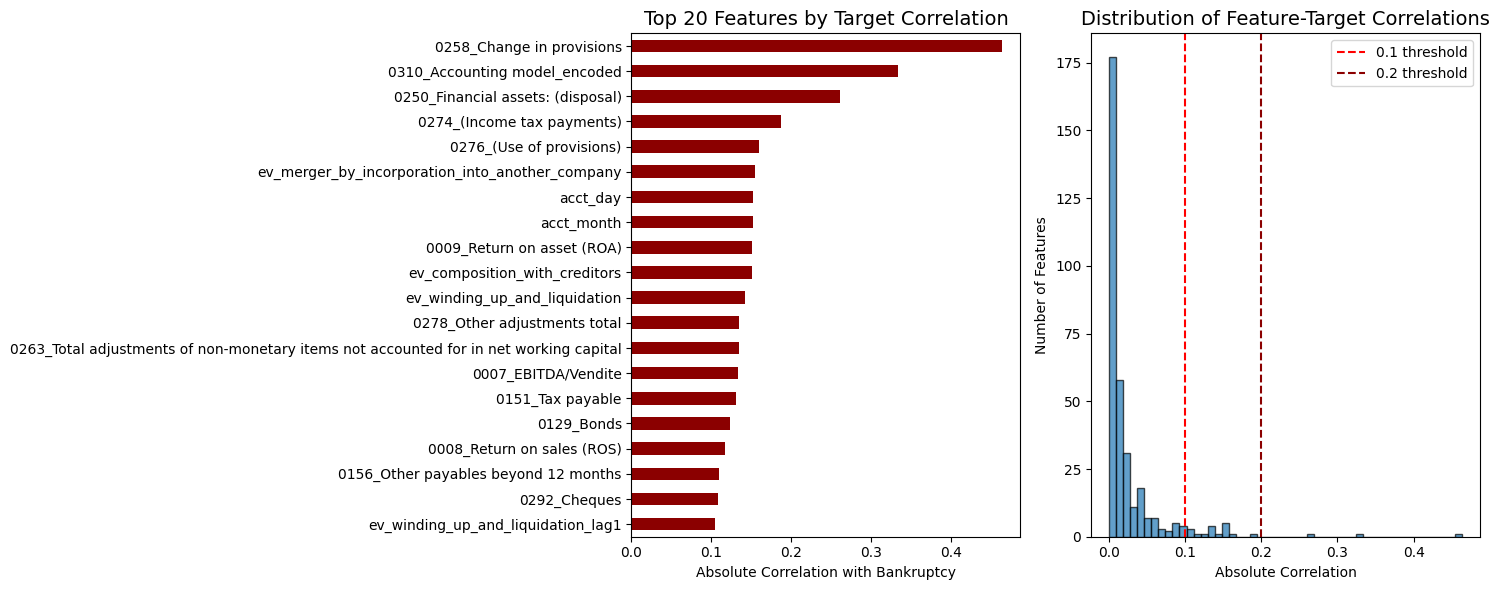


📊 FEATURE IMPORTANCE BY TYPE:
Average correlation with target:
  - Event features: 0.0331
  - Financial features: 0.0236

⚠️ Features with correlation < 0.01: 184
These features have almost no predictive power


In [ ]:
#@title Analyze Correlations with Target Variable
# Calculate correlations with target
feature_cols = [col for col in df_ready_clean.columns if col not in ['Tax code number', 'Year', 'Target']]
target_correlations = df_ready_clean[feature_cols].corrwith(df_ready_clean['Target']).abs().sort_values(ascending=False)

print("🎯 TOP FEATURES CORRELATED WITH BANKRUPTCY (Target)")
print("=" * 80)
print("Top 30 most predictive features:")
print(target_correlations.head(30).to_frame('Correlation with Target'))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top features bar plot
target_correlations.head(20).plot(kind='barh', ax=ax1, color='darkred')
ax1.set_title('Top 20 Features by Target Correlation', fontsize=14)
ax1.set_xlabel('Absolute Correlation with Bankruptcy')
ax1.invert_yaxis()

# Distribution of correlations
ax2.hist(target_correlations.values, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0.1, color='red', linestyle='--', label='0.1 threshold')
ax2.axvline(x=0.2, color='darkred', linestyle='--', label='0.2 threshold')
ax2.set_title('Distribution of Feature-Target Correlations', fontsize=14)
ax2.set_xlabel('Absolute Correlation')
ax2.set_ylabel('Number of Features')
ax2.legend()

plt.tight_layout()
plt.show()

# Analyze by feature type
print("\n📊 FEATURE IMPORTANCE BY TYPE:")
event_features = [f for f in feature_cols if f.startswith('ev_')]
financial_features = [f for f in feature_cols if f not in event_features]

event_corr = target_correlations[event_features].mean()
financial_corr = target_correlations[financial_features].mean()

print(f"Average correlation with target:")
print(f"  - Event features: {event_corr:.4f}")
print(f"  - Financial features: {financial_corr:.4f}")

# Features with very low correlation
low_corr_features = target_correlations[target_correlations < 0.01]
print(f"\n⚠️ Features with correlation < 0.01: {len(low_corr_features)}")
print("These features have almost no predictive power")

In [ ]:
#@title Final Data Quality Check Before Modeling
print("✅ FINAL DATA QUALITY CHECKLIST")
print("=" * 80)

# 1. Data types
print("1. Data Types:")
print(f"   - All numeric: {'✓' if df_ready_clean.select_dtypes(include=['object']).empty else '✗'}")
print(f"   - Shape: {df_ready_clean.shape}")

# 2. Missing values
missing_pct = (df_ready_clean.isnull().sum() / len(df_ready_clean) * 100)
print(f"\n2. Missing Values:")
print(f"   - Columns with >50% missing: {(missing_pct > 50).sum()}")
print(f"   - Columns with >90% missing: {(missing_pct > 90).sum()}")

# 3. Target distribution
print(f"\n3. Target Distribution:")
print(f"   - Overall: {df_ready_clean['Target'].mean():.2%} bankruptcy rate")
print(f"   - Class ratio: {(df_ready_clean['Target']==0).sum()/(df_ready_clean['Target']==1).sum():.1f}:1")

# 4. Temporal splits
print(f"\n4. Temporal Splits:")
for years, name in [((2014, 2018), 'Train'), ((2019, 2019), 'Valid'), ((2020, 2022), 'Test')]:
    mask = df_ready_clean['Year'].between(years[0], years[1])
    print(f"   - {name}: {mask.sum():,} samples, {df_ready_clean[mask]['Target'].mean():.2%} positive")

# 5. Key features
print(f"\n5. Feature Summary:")
print(f"   - Total features: {len(feature_cols)}")
print(f"   - Event features: {len([f for f in feature_cols if f.startswith('ev_')])}")
print(f"   - Features with >0.1 target correlation: {(target_correlations > 0.1).sum()}")

print("\n🚀 Ready for modeling? Let's check:")
ready_checks = [
    ("No string columns", df_ready_clean.select_dtypes(include=['object']).empty),
    ("Have target variable", 'Target' in df_ready_clean.columns),
    ("Have temporal splits", df_ready_clean['Year'].min() < df_ready_clean['Year'].max()),
    ("Have both classes", df_ready_clean['Target'].nunique() == 2),
    ("Reasonable number of features", len(feature_cols) > 10)
]

all_ready = all(check[1] for check in ready_checks)
for check_name, check_result in ready_checks:
    print(f"   {'✓' if check_result else '✗'} {check_name}")

if all_ready:
    print("\n✅ ALL SYSTEMS GO! Ready to build models!")
else:
    print("\n⚠️ Some issues need addressing before modeling")

✅ FINAL DATA QUALITY CHECKLIST
1. Data Types:
   - All numeric: ✓
   - Shape: (16721, 446)

2. Missing Values:
   - Columns with >50% missing: 268
   - Columns with >90% missing: 168

3. Target Distribution:
   - Overall: 8.16% bankruptcy rate
   - Class ratio: 11.3:1

4. Temporal Splits:
   - Train: 11,376 samples, 5.73% positive
   - Valid: 1,710 samples, 14.27% positive
   - Test: 3,635 samples, 12.87% positive

5. Feature Summary:
   - Total features: 443
   - Event features: 84
   - Features with >0.1 target correlation: 21

🚀 Ready for modeling? Let's check:
   ✓ No string columns
   ✓ Have target variable
   ✓ Have temporal splits
   ✓ Have both classes
   ✓ Reasonable number of features

✅ ALL SYSTEMS GO! Ready to build models!


In [ ]:
#@title Quick Check on Missing Values and Final Data Prep
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

print("✅ FINAL PRE-MODELING CHECKS")
print("=" * 80)

# Check if we have the clean dataset ready
if 'df_ready_clean' not in locals():
    print("⚠️ Need to run data cleaning first!")
else:
    # Remove columns with too many missing values
    missing_pct = (df_ready_clean.isnull().sum() / len(df_ready_clean) * 100)
    high_missing_cols = missing_pct[missing_pct > 90].index.tolist()

    print(f"Removing {len(high_missing_cols)} columns with >90% missing values")
    df_model_ready = df_ready_clean.drop(columns=high_missing_cols, errors='ignore')

    # Final feature list
    feature_cols = [col for col in df_model_ready.columns
                   if col not in ['Tax code number', 'Year', 'Target']]

    print(f"\nFinal dataset shape: {df_model_ready.shape}")
    print(f"Features for modeling: {len(feature_cols)}")
    print(f"Target rate: {df_model_ready['Target'].mean():.2%}")

    # Class weights for modeling - FIX: use numpy array
    classes = np.array([0, 1])
    class_weights = compute_class_weight('balanced', classes=classes, y=df_model_ready['Target'])
    class_weight_dict = dict(zip(classes, class_weights))

    print(f"\nClass weights for balanced training:")
    print(f"  Class 0 (healthy): {class_weight_dict[0]:.2f}")
    print(f"  Class 1 (failure): {class_weight_dict[1]:.2f}")
    print(f"  XGBoost scale_pos_weight: {class_weight_dict[1]/class_weight_dict[0]:.2f}")

✅ FINAL PRE-MODELING CHECKS
Removing 168 columns with >90% missing values

Final dataset shape: (16721, 278)
Features for modeling: 275
Target rate: 8.16%

Class weights for balanced training:
  Class 0 (healthy): 0.54
  Class 1 (failure): 6.13
  XGBoost scale_pos_weight: 11.26


### MODEL

In [ ]:
#@title 🚀 Comprehensive Model Comparison with Hyperparameter Optimization

#================================================================================
# CONFIGURATION PARAMETERS - MODIFY THESE AS NEEDED
#================================================================================

# Optuna Settings
OPTUNA_TRIALS = 50  # Number of trials per model (increase for better results)
OPTUNA_TIMEOUT = 300  # Timeout in seconds per model
USE_OPTUNA = True  # Set to False to use default parameters

# Model Training Settings
RANDOM_STATE = 42
EARLY_STOPPING_ROUNDS = 50
MAX_ITERATIONS = 300

# Hyperparameter Search Ranges
PARAM_RANGES = {
    'logistic': {
        'C': (0.001, 10.0),  # Inverse regularization strength
    },
    'random_forest': {
        'n_estimators': (50, 500),
        'max_depth': (3, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'xgboost': {
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (100, 500),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
        'reg_alpha': (0.001, 10.0),
        'reg_lambda': (0.001, 10.0)
    },
    'lightgbm': {
        'num_leaves': (20, 300),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (100, 500),
        'feature_fraction': (0.5, 1.0),
        'bagging_fraction': (0.5, 1.0),
        'bagging_freq': (1, 10),
        'reg_alpha': (0.001, 10.0),
        'reg_lambda': (0.001, 10.0)
    },
    'neural_network': {
        'hidden_layer_1': (32, 256),
        'hidden_layer_2': (16, 128),
        'dropout_rate': (0.1, 0.5),
        'learning_rate': (0.0001, 0.01),
        'batch_size': [32, 64, 128],
        'epochs': (50, 200)
    }
}

#================================================================================
# IMPORTS AND SETUP
#================================================================================

# Install required packages
!pip install -q xgboost lightgbm optuna scikit-learn tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           precision_recall_curve, roc_curve,
                           confusion_matrix, classification_report,
                           brier_score_loss, f1_score)
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
import optuna
from optuna.visualization import plot_optimization_history
import time
import warnings
import re
from IPython.display import clear_output, display
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

#================================================================================
# PROGRESS TRACKING SYSTEM
#================================================================================

class ModelTracker:
    def __init__(self, total_models=5):
        self.total_models = total_models
        self.current_model = 0
        self.results_summary = []
        self.start_time = time.time()

    def update(self, model_name, status, metrics=None, trial=None, total_trials=None):
        self.current_time = time.time() - self.start_time

        # Clear and redraw
        clear_output(wait=True)

        # Header
        print("🚀 COMPREHENSIVE BANKRUPTCY PREDICTION MODEL COMPARISON")
        print("=" * 80)
        print(f"⏱️  Elapsed Time: {self.current_time:.1f}s")
        print(f"🔧 Configuration: Optuna={'ON' if USE_OPTUNA else 'OFF'} | Trials={OPTUNA_TRIALS}")
        print("=" * 80)

        # Current model status
        print(f"\n📊 Current Model: {model_name}")
        print(f"📈 Status: {status}")

        # Optuna progress bar if applicable
        if trial is not None and total_trials is not None:
            progress = trial / total_trials
            bar_length = 50
            filled_length = int(bar_length * progress)
            bar = '█' * filled_length + '░' * (bar_length - filled_length)
            print(f"🔍 Optimization: [{bar}] {trial}/{total_trials} trials")

        # Overall progress
        print(f"\n🏃 Overall Progress: {self.current_model}/{self.total_models} models")
        overall_progress = self.current_model / self.total_models
        bar_length = 50
        filled_length = int(bar_length * overall_progress)
        bar = '█' * filled_length + '░' * (bar_length - filled_length)
        print(f"   [{bar}] {overall_progress*100:.0f}%")

        # Results so far
        if self.results_summary:
            print("\n📊 Results Summary:")
            print("-" * 60)
            print(f"{'Model':<20} {'Train Time':<12} {'Test ROC-AUC':<12} {'Status':<10}")
            print("-" * 60)
            for result in self.results_summary:
                print(f"{result['model']:<20} {result['time']:<12} {result['auc']:<12} ✅")

        if metrics:
            print(f"\n🎯 Current Metrics: {metrics}")

    def complete_model(self, model_name, train_time, test_auc):
        self.current_model += 1
        self.results_summary.append({
            'model': model_name,
            'time': f"{train_time:.1f}s",
            'auc': f"{test_auc:.4f}"
        })

# Initialize tracker
tracker = ModelTracker(total_models=5)

#================================================================================
# DATA PREPARATION
#================================================================================

tracker.update("Data Preparation", "Loading and splitting data...")

# Create temporal splits
X = df_model_ready[feature_cols]
y = df_model_ready['Target']

# Temporal splits
train_mask = df_model_ready['Year'].between(2014, 2018)
valid_mask = df_model_ready['Year'] == 2019
test_mask = df_model_ready['Year'].between(2020, 2022)

X_train, y_train = X[train_mask], y[train_mask]
X_valid, y_valid = X[valid_mask], y[valid_mask]
X_test, y_test = X[test_mask], y[test_mask]

# Calculate class weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
class_weight_dict = {0: 1.0, 1: scale_pos_weight}

# Sanitize feature names for LightGBM
def sanitize_features(df):
    df = df.copy()
    df.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', c) for c in df.columns]
    return df

X_train_sanitized = sanitize_features(X_train)
X_valid_sanitized = sanitize_features(X_valid)
X_test_sanitized = sanitize_features(X_test)

# Save feature names
feature_names = list(feature_cols)
feature_names_sanitized = list(X_train_sanitized.columns)

tracker.update("Data Preparation", "Data loaded and split successfully!",
              f"Train: {X_train.shape} | Valid: {X_valid.shape} | Test: {X_test.shape}")
time.sleep(2)

# Initialize storage
results = []
models = {}
predictions = {}
best_params = {}

#================================================================================
# OPTUNA OPTIMIZATION FUNCTIONS
#================================================================================

def create_neural_network(input_dim, hidden_1, hidden_2, dropout_rate, learning_rate):
    """Create a neural network with given parameters."""
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(hidden_1, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(hidden_2, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

#================================================================================
# MODEL 1: LOGISTIC REGRESSION
#================================================================================

tracker.update("Logistic Regression", "Initializing...")

if USE_OPTUNA:
    def objective_logistic(trial):
        tracker.update("Logistic Regression", "Optimizing hyperparameters...",
                      trial=trial.number + 1, total_trials=OPTUNA_TRIALS)

        C = trial.suggest_float('C', *PARAM_RANGES['logistic']['C'], log=True)

        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                penalty='l1',
                solver='liblinear',
                C=C,
                class_weight='balanced',
                max_iter=1000,
                random_state=RANDOM_STATE
            ))
        ])

        # Use cross-validation on training set
        cv_scores = cross_val_score(
            pipeline, X_train, y_train,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
            scoring='roc_auc'
        )
        return cv_scores.mean()

    study_logistic = optuna.create_study(direction='maximize')
    study_logistic.optimize(objective_logistic, n_trials=OPTUNA_TRIALS, timeout=OPTUNA_TIMEOUT)
    best_params['Logistic_L1'] = study_logistic.best_params
    C_optimal = study_logistic.best_params['C']
    tracker.update("Logistic Regression", "Optimization complete!",
                  f"Best C: {C_optimal:.4f}")
else:
    C_optimal = 1.0
    best_params['Logistic_L1'] = {'C': C_optimal}

# Train final model
tracker.update("Logistic Regression", "Training final model...")

log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        C=C_optimal,
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

start_time = time.time()
log_pipeline.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_train_pred_log = log_pipeline.predict_proba(X_train)[:, 1]
y_valid_pred_log = log_pipeline.predict_proba(X_valid)[:, 1]
y_test_pred_log = log_pipeline.predict_proba(X_test)[:, 1]

# Store results
models['Logistic_L1'] = log_pipeline
predictions['Logistic_L1'] = {
    'train': y_train_pred_log,
    'valid': y_valid_pred_log,
    'test': y_test_pred_log
}

test_roc = roc_auc_score(y_test, y_test_pred_log)
results.append({
    'Model': 'Logistic_L1',
    'Train_Time': train_time,
    'Train_ROCAUC': roc_auc_score(y_train, y_train_pred_log),
    'Valid_ROCAUC': roc_auc_score(y_valid, y_valid_pred_log),
    'Test_ROCAUC': test_roc,
    'Test_PRAUC': average_precision_score(y_test, y_test_pred_log),
    'Test_Brier': brier_score_loss(y_test, y_test_pred_log)
})

tracker.complete_model("Logistic_L1", train_time, test_roc)
tracker.update("Logistic Regression", "Completed!", f"Test ROC-AUC: {test_roc:.4f}")
time.sleep(1)

#================================================================================
# MODEL 2: RANDOM FOREST
#================================================================================

tracker.update("Random Forest", "Initializing...")

if USE_OPTUNA:
    def objective_rf(trial):
        tracker.update("Random Forest", "Optimizing hyperparameters...",
                      trial=trial.number + 1, total_trials=OPTUNA_TRIALS)

        params = {
            'n_estimators': trial.suggest_int('n_estimators', *PARAM_RANGES['random_forest']['n_estimators']),
            'max_depth': trial.suggest_int('max_depth', *PARAM_RANGES['random_forest']['max_depth']),
            'min_samples_split': trial.suggest_int('min_samples_split', *PARAM_RANGES['random_forest']['min_samples_split']),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', *PARAM_RANGES['random_forest']['min_samples_leaf']),
            'max_features': trial.suggest_categorical('max_features', PARAM_RANGES['random_forest']['max_features']),
            'bootstrap': trial.suggest_categorical('bootstrap', PARAM_RANGES['random_forest']['bootstrap'])
        }

        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('classifier', RandomForestClassifier(
                **params,
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1
            ))
        ])

        cv_scores = cross_val_score(
            pipeline, X_train, y_train,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
            scoring='roc_auc'
        )
        return cv_scores.mean()

    study_rf = optuna.create_study(direction='maximize')
    study_rf.optimize(objective_rf, n_trials=OPTUNA_TRIALS, timeout=OPTUNA_TIMEOUT)
    best_params['RandomForest'] = study_rf.best_params
    rf_params = study_rf.best_params
    tracker.update("Random Forest", "Optimization complete!",
                  f"Best n_estimators: {rf_params['n_estimators']}")
else:
    rf_params = {
        'n_estimators': 200,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'bootstrap': True
    }
    best_params['RandomForest'] = rf_params

# Train final model
tracker.update("Random Forest", "Training final model...")

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', RandomForestClassifier(
        **rf_params,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

start_time = time.time()
rf_pipeline.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_train_pred_rf = rf_pipeline.predict_proba(X_train)[:, 1]
y_valid_pred_rf = rf_pipeline.predict_proba(X_valid)[:, 1]
y_test_pred_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Store results
models['RandomForest'] = rf_pipeline
predictions['RandomForest'] = {
    'train': y_train_pred_rf,
    'valid': y_valid_pred_rf,
    'test': y_test_pred_rf
}

test_roc = roc_auc_score(y_test, y_test_pred_rf)
results.append({
    'Model': 'RandomForest',
    'Train_Time': train_time,
    'Train_ROCAUC': roc_auc_score(y_train, y_train_pred_rf),
    'Valid_ROCAUC': roc_auc_score(y_valid, y_valid_pred_rf),
    'Test_ROCAUC': test_roc,
    'Test_PRAUC': average_precision_score(y_test, y_test_pred_rf),
    'Test_Brier': brier_score_loss(y_test, y_test_pred_rf)
})

tracker.complete_model("RandomForest", train_time, test_roc)
tracker.update("Random Forest", "Completed!", f"Test ROC-AUC: {test_roc:.4f}")
time.sleep(1)

#================================================================================
# MODEL 3: XGBOOST
#================================================================================

tracker.update("XGBoost", "Initializing...")

if USE_OPTUNA:
    def objective_xgb(trial):
        tracker.update("XGBoost", "Optimizing hyperparameters...",
                      trial=trial.number + 1, total_trials=OPTUNA_TRIALS)

        params = {
            'max_depth': trial.suggest_int('max_depth', *PARAM_RANGES['xgboost']['max_depth']),
            'learning_rate': trial.suggest_float('learning_rate', *PARAM_RANGES['xgboost']['learning_rate'], log=True),
            'n_estimators': trial.suggest_int('n_estimators', *PARAM_RANGES['xgboost']['n_estimators']),
            'subsample': trial.suggest_float('subsample', *PARAM_RANGES['xgboost']['subsample']),
            'colsample_bytree': trial.suggest_float('colsample_bytree', *PARAM_RANGES['xgboost']['colsample_bytree']),
            'reg_alpha': trial.suggest_float('reg_alpha', *PARAM_RANGES['xgboost']['reg_alpha'], log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', *PARAM_RANGES['xgboost']['reg_lambda'], log=True)
        }

        model = xgb.XGBClassifier(
            **params,
            objective='binary:logistic',
            scale_pos_weight=scale_pos_weight,
            seed=RANDOM_STATE,
            eval_metric='auc',
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbosity=0
        )

        # Simple imputation for XGBoost
        X_train_imp = SimpleImputer(strategy='median').fit_transform(X_train)
        X_valid_imp = SimpleImputer(strategy='median').fit_transform(X_valid)

        model.fit(
            X_train_imp, y_train,
            eval_set=[(X_valid_imp, y_valid)],
            verbose=False
        )

        return model.best_score

    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective_xgb, n_trials=OPTUNA_TRIALS, timeout=OPTUNA_TIMEOUT)
    best_params['XGBoost'] = study_xgb.best_params
    xgb_params = study_xgb.best_params
    tracker.update("XGBoost", "Optimization complete!",
                  f"Best max_depth: {xgb_params['max_depth']}")
else:
    xgb_params = {
        'max_depth': 6,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0
    }
    best_params['XGBoost'] = xgb_params

# Train final model
tracker.update("XGBoost", "Training final model...")

imputer_xgb = SimpleImputer(strategy='median')
X_train_imp = imputer_xgb.fit_transform(X_train)
X_valid_imp = imputer_xgb.transform(X_valid)
X_test_imp = imputer_xgb.transform(X_test)

xgb_model = xgb.XGBClassifier(
    **xgb_params,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    seed=RANDOM_STATE,
    eval_metric='auc',
    early_stopping_rounds=EARLY_STOPPING_ROUNDS
)

start_time = time.time()
xgb_model.fit(
    X_train_imp, y_train,
    eval_set=[(X_valid_imp, y_valid)],
    verbose=False
)
train_time = time.time() - start_time

# Predictions
y_train_pred_xgb = xgb_model.predict_proba(X_train_imp)[:, 1]
y_valid_pred_xgb = xgb_model.predict_proba(X_valid_imp)[:, 1]
y_test_pred_xgb = xgb_model.predict_proba(X_test_imp)[:, 1]

# Store results
models['XGBoost'] = xgb_model
predictions['XGBoost'] = {
    'train': y_train_pred_xgb,
    'valid': y_valid_pred_xgb,
    'test': y_test_pred_xgb
}

test_roc = roc_auc_score(y_test, y_test_pred_xgb)
results.append({
    'Model': 'XGBoost',
    'Train_Time': train_time,
    'Train_ROCAUC': roc_auc_score(y_train, y_train_pred_xgb),
    'Valid_ROCAUC': roc_auc_score(y_valid, y_valid_pred_xgb),
    'Test_ROCAUC': test_roc,
    'Test_PRAUC': average_precision_score(y_test, y_test_pred_xgb),
    'Test_Brier': brier_score_loss(y_test, y_test_pred_xgb)
})

tracker.complete_model("XGBoost", train_time, test_roc)
tracker.update("XGBoost", "Completed!",
              f"Test ROC-AUC: {test_roc:.4f} | Best iter: {xgb_model.best_iteration}")
time.sleep(1)

#================================================================================
# MODEL 4: LIGHTGBM
#================================================================================

tracker.update("LightGBM", "Initializing...")

if USE_OPTUNA:
    def objective_lgb(trial):
        tracker.update("LightGBM", "Optimizing hyperparameters...",
                      trial=trial.number + 1, total_trials=OPTUNA_TRIALS)

        params = {
            'num_leaves': trial.suggest_int('num_leaves', *PARAM_RANGES['lightgbm']['num_leaves']),
            'learning_rate': trial.suggest_float('learning_rate', *PARAM_RANGES['lightgbm']['learning_rate'], log=True),
            'n_estimators': trial.suggest_int('n_estimators', *PARAM_RANGES['lightgbm']['n_estimators']),
            'feature_fraction': trial.suggest_float('feature_fraction', *PARAM_RANGES['lightgbm']['feature_fraction']),
            'bagging_fraction': trial.suggest_float('bagging_fraction', *PARAM_RANGES['lightgbm']['bagging_fraction']),
            'bagging_freq': trial.suggest_int('bagging_freq', *PARAM_RANGES['lightgbm']['bagging_freq']),
            'reg_alpha': trial.suggest_float('reg_alpha', *PARAM_RANGES['lightgbm']['reg_alpha'], log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', *PARAM_RANGES['lightgbm']['reg_lambda'], log=True)
        }

        model = lgb.LGBMClassifier(
            **params,
            objective='binary',
            is_unbalance=True,
            boosting_type='gbdt',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=-1
        )

        model.fit(
            X_train_sanitized, y_train,
            eval_set=[(X_valid_sanitized, y_valid)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS), lgb.log_evaluation(0)]
        )

        return model.best_score_['valid_0']['auc']

    study_lgb = optuna.create_study(direction='maximize')
    study_lgb.optimize(objective_lgb, n_trials=OPTUNA_TRIALS, timeout=OPTUNA_TIMEOUT)
    best_params['LightGBM'] = study_lgb.best_params
    lgb_params = study_lgb.best_params
    tracker.update("LightGBM", "Optimization complete!",
                  f"Best num_leaves: {lgb_params['num_leaves']}")
else:
    lgb_params = {
        'num_leaves': 31,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0
    }
    best_params['LightGBM'] = lgb_params

# Train final model
tracker.update("LightGBM", "Training final model...")

lgb_model = lgb.LGBMClassifier(
    **lgb_params,
    objective='binary',
    is_unbalance=True,
    boosting_type='gbdt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

start_time = time.time()
lgb_model.fit(
    X_train_sanitized, y_train,
    eval_set=[(X_valid_sanitized, y_valid)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS), lgb.log_evaluation(0)]
)
train_time = time.time() - start_time

# Predictions
y_train_pred_lgb = lgb_model.predict_proba(X_train_sanitized)[:, 1]
y_valid_pred_lgb = lgb_model.predict_proba(X_valid_sanitized)[:, 1]
y_test_pred_lgb = lgb_model.predict_proba(X_test_sanitized)[:, 1]

# Store results
models['LightGBM'] = lgb_model
predictions['LightGBM'] = {
    'train': y_train_pred_lgb,
    'valid': y_valid_pred_lgb,
    'test': y_test_pred_lgb
}

test_roc = roc_auc_score(y_test, y_test_pred_lgb)
results.append({
    'Model': 'LightGBM',
    'Train_Time': train_time,
    'Train_ROCAUC': roc_auc_score(y_train, y_train_pred_lgb),
    'Valid_ROCAUC': roc_auc_score(y_valid, y_valid_pred_lgb),
    'Test_ROCAUC': test_roc,
    'Test_PRAUC': average_precision_score(y_test, y_test_pred_lgb),
    'Test_Brier': brier_score_loss(y_test, y_test_pred_lgb)
})

tracker.complete_model("LightGBM", train_time, test_roc)
tracker.update("LightGBM", "Completed!",
              f"Test ROC-AUC: {test_roc:.4f} | Best iter: {lgb_model.best_iteration_}")
time.sleep(1)

#================================================================================
# MODEL 5: NEURAL NETWORK
#================================================================================

tracker.update("Neural Network", "Initializing...")

# Prepare data for neural network
scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')

X_train_nn = scaler.fit_transform(imputer.fit_transform(X_train))
X_valid_nn = scaler.transform(imputer.transform(X_valid))
X_test_nn = scaler.transform(imputer.transform(X_test))

# Custom callback for progress tracking
class NNProgressCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0 or epoch == self.total_epochs - 1:
            tracker.update("Neural Network",
                          f"Training epoch {epoch+1}/{self.total_epochs}",
                          f"Val AUC: {logs.get('val_auc', 0):.4f}")

if USE_OPTUNA:
    def objective_nn(trial):
        tracker.update("Neural Network", "Optimizing hyperparameters...",
                      trial=trial.number + 1, total_trials=OPTUNA_TRIALS//2)

        params = {
            'hidden_1': trial.suggest_int('hidden_1', *PARAM_RANGES['neural_network']['hidden_layer_1']),
            'hidden_2': trial.suggest_int('hidden_2', *PARAM_RANGES['neural_network']['hidden_layer_2']),
            'dropout_rate': trial.suggest_float('dropout_rate', *PARAM_RANGES['neural_network']['dropout_rate']),
            'learning_rate': trial.suggest_float('learning_rate', *PARAM_RANGES['neural_network']['learning_rate'], log=True),
            'batch_size': trial.suggest_categorical('batch_size', PARAM_RANGES['neural_network']['batch_size']),
            'epochs': trial.suggest_int('epochs', *PARAM_RANGES['neural_network']['epochs'])
        }

       model = create_neural_network(
           input_dim=X_train_nn.shape[1],
           hidden_1=params['hidden_1'],
           hidden_2=params['hidden_2'],
           dropout_rate=params['dropout_rate'],
           learning_rate=params['learning_rate']
       )

       # Use class weights for imbalanced data
       class_weights = {0: 1.0, 1: scale_pos_weight}

       history = model.fit(
           X_train_nn, y_train,
           validation_data=(X_valid_nn, y_valid),
           epochs=params['epochs'],
           batch_size=params['batch_size'],
           class_weight=class_weights,
           verbose=0,
           callbacks=[
               keras.callbacks.EarlyStopping(
                   monitor='val_auc',
                   patience=10,
                   mode='max',
                   restore_best_weights=True
               )
           ]
       )

       # Return best validation AUC
       return max(history.history['val_auc'])

   study_nn = optuna.create_study(direction='maximize')
   study_nn.optimize(objective_nn, n_trials=OPTUNA_TRIALS//2, timeout=OPTUNA_TIMEOUT)  # Fewer trials for NN
   best_params['NeuralNetwork'] = study_nn.best_params
   nn_params = study_nn.best_params
   tracker.update("Neural Network", "Optimization complete!",
                 f"Best architecture: {nn_params['hidden_1']}-{nn_params['hidden_2']}")


else:
   nn_params = {
       'hidden_1': 128,
       'hidden_2': 64,
       'dropout_rate': 0.3,
       'learning_rate': 0.001,
       'batch_size': 64,
       'epochs': 100
   }
   best_params['NeuralNetwork'] = nn_params

# Train final model
tracker.update("Neural Network", "Training final model...")

nn_model = create_neural_network(
   input_dim=X_train_nn.shape[1],
   hidden_1=nn_params['hidden_1'],
   hidden_2=nn_params['hidden_2'],
   dropout_rate=nn_params['dropout_rate'],
   learning_rate=nn_params['learning_rate']
)

start_time = time.time()
history = nn_model.fit(
   X_train_nn, y_train,
   validation_data=(X_valid_nn, y_valid),
   epochs=nn_params['epochs'],
   batch_size=nn_params['batch_size'],
   class_weight={0: 1.0, 1: scale_pos_weight},
   verbose=0,
   callbacks=[
       NNProgressCallback(nn_params['epochs']),
       keras.callbacks.EarlyStopping(
           monitor='val_auc',
           patience=10,
           mode='max',
           restore_best_weights=True
       )
   ]
)
train_time = time.time() - start_time

# Predictions
y_train_pred_nn = nn_model.predict(X_train_nn).flatten()
y_valid_pred_nn = nn_model.predict(X_valid_nn).flatten()
y_test_pred_nn = nn_model.predict(X_test_nn).flatten()

# Store results
models['NeuralNetwork'] = nn_model
predictions['NeuralNetwork'] = {
   'train': y_train_pred_nn,
   'valid': y_valid_pred_nn,
   'test': y_test_pred_nn
}

test_roc = roc_auc_score(y_test, y_test_pred_nn)
results.append({
   'Model': 'NeuralNetwork',
   'Train_Time': train_time,
   'Train_ROCAUC': roc_auc_score(y_train, y_train_pred_nn),
   'Valid_ROCAUC': roc_auc_score(y_valid, y_valid_pred_nn),
   'Test_ROCAUC': test_roc,
   'Test_PRAUC': average_precision_score(y_test, y_test_pred_nn),
   'Test_Brier': brier_score_loss(y_test, y_test_pred_nn)
})

tracker.complete_model("NeuralNetwork", train_time, test_roc)
tracker.update("Neural Network", "Completed!",
             f"Test ROC-AUC: {test_roc:.4f} | Final epoch: {len(history.history['loss'])}")
time.sleep(1)

#================================================================================
# RESULTS SUMMARY
#================================================================================

# Final update showing all results
tracker.update("All Models Complete!", "Preparing final results...")
time.sleep(2)

# Clear output one final time for clean results display
clear_output(wait=True)

print("🚀 COMPREHENSIVE BANKRUPTCY PREDICTION MODEL COMPARISON")
print("=" * 80)
print(f"✅ All models trained successfully!")
print(f"⏱️  Total time: {time.time() - tracker.start_time:.1f}s")
print(f"🔧 Configuration: Optuna={'ON' if USE_OPTUNA else 'OFF'} | Trials={OPTUNA_TRIALS}")
print("=" * 80)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Calculate optimal thresholds and F1 scores
for idx, row in results_df.iterrows():
   model_name = row['Model']
   y_pred = predictions[model_name]['test']

   # Find optimal threshold based on F1 score
   thresholds = np.linspace(0, 1, 100)
   f1_scores = [f1_score(y_test, (y_pred > t).astype(int)) for t in thresholds]
   optimal_idx = np.argmax(f1_scores)

   results_df.at[idx, 'Optimal_Threshold'] = thresholds[optimal_idx]
   results_df.at[idx, 'Test_F1'] = f1_scores[optimal_idx]

# Sort by Test ROC-AUC
results_df = results_df.sort_values('Test_ROCAUC', ascending=False)

# Display results
print("\n📊 MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(results_df.round(4).to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name} (ROC-AUC: {results_df.iloc[0]['Test_ROCAUC']:.4f})")

# Show hyperparameters
if USE_OPTUNA:
   print("\n🔧 OPTIMIZED HYPERPARAMETERS")
   print("=" * 80)
   for model_name, params in best_params.items():
       print(f"\n{model_name}:")
       for param, value in params.items():
           print(f"  • {param}: {value}")

#================================================================================
# VISUALIZATION
#================================================================================

# Set up the plot style
plt.style.use('seaborn-v0_8-darkgrid')
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. ROC Curves
ax1 = plt.subplot(3, 3, 1)
for i, (model_name, color) in enumerate(zip(models.keys(), colors)):
   fpr, tpr, _ = roc_curve(y_test, predictions[model_name]['test'])
   auc_score = roc_auc_score(y_test, predictions[model_name]['test'])
   ax1.plot(fpr, tpr, linewidth=2, color=color, label=f'{model_name} (AUC={auc_score:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - Test Set', fontsize=14)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = plt.subplot(3, 3, 2)
baseline = y_test.mean()
for i, (model_name, color) in enumerate(zip(models.keys(), colors)):
   precision, recall, _ = precision_recall_curve(y_test, predictions[model_name]['test'])
   pr_auc = average_precision_score(y_test, predictions[model_name]['test'])
   ax2.plot(recall, precision, linewidth=2, color=color, label=f'{model_name} (AUC={pr_auc:.3f})')
ax2.axhline(y=baseline, color='k', linestyle='--', linewidth=1, label=f'Baseline ({baseline:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves - Test Set', fontsize=14)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Model Performance Comparison
ax3 = plt.subplot(3, 3, 3)
metrics_comparison = results_df.set_index('Model')[['Test_ROCAUC', 'Test_PRAUC', 'Test_F1']].head(10)
metrics_comparison.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Model Performance Metrics', fontsize=14)
ax3.set_ylabel('Score')
ax3.set_xlabel('')
ax3.legend(['ROC-AUC', 'PR-AUC', 'F1 Score'])
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Score Distributions
ax4 = plt.subplot(3, 3, 4)
for i, (model_name, color) in enumerate(zip(models.keys(), colors)):
   y_pred = predictions[model_name]['test']
   ax4.hist(y_pred[y_test == 1], bins=30, alpha=0.5, density=True,
            color=color, label=f'{model_name} (Failure)', histtype='step', linewidth=2)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Score Distributions - Failure Class', fontsize=14)
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

# 5. Training Time Comparison
ax5 = plt.subplot(3, 3, 5)
time_df = results_df.set_index('Model')['Train_Time'].sort_values()
time_df.plot(kind='barh', ax=ax5, color='skyblue')
ax5.set_xlabel('Training Time (seconds)')
ax5.set_title('Model Training Time', fontsize=14)
ax5.grid(True, alpha=0.3, axis='x')

# 6. Overfitting Analysis
ax6 = plt.subplot(3, 3, 6)
overfitting_data = results_df.set_index('Model')[['Train_ROCAUC', 'Test_ROCAUC']]
x = np.arange(len(overfitting_data))
width = 0.35
ax6.bar(x - width/2, overfitting_data['Train_ROCAUC'], width, label='Train', alpha=0.8)
ax6.bar(x + width/2, overfitting_data['Test_ROCAUC'], width, label='Test', alpha=0.8)
ax6.set_xlabel('Model')
ax6.set_ylabel('ROC-AUC')
ax6.set_title('Train vs Test Performance', fontsize=14)
ax6.set_xticks(x)
ax6.set_xticklabels(overfitting_data.index, rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# 7. Feature Importance (for best tree-based model)
ax7 = plt.subplot(3, 3, 7)
tree_models = ['XGBoost', 'LightGBM', 'RandomForest']
best_tree_model = None
for model in tree_models:
   if model in models and model == best_model_name:
       best_tree_model = model
       break
if not best_tree_model:  # If best model isn't tree-based, use best tree model
   for model in tree_models:
       if model in models:
           best_tree_model = model
           break

if best_tree_model:
   if best_tree_model == 'LightGBM':
       feature_importance = pd.DataFrame({
           'feature': feature_names,
           'importance': models[best_tree_model].feature_importances_
       })
   else:
       feature_importance = pd.DataFrame({
           'feature': feature_names,
           'importance': models[best_tree_model].named_steps['classifier'].feature_importances_
           if 'RandomForest' in best_tree_model else models[best_tree_model].feature_importances_
       })

   top_features = feature_importance.nlargest(15, 'importance')
   top_features.plot(x='feature', y='importance', kind='barh', ax=ax7, legend=False)
   ax7.set_xlabel('Importance')
   ax7.set_title(f'Top 15 Features - {best_tree_model}', fontsize=14)
   ax7.invert_yaxis()

# 8. Calibration Plot
ax8 = plt.subplot(3, 3, 8)
from sklearn.calibration import calibration_curve
n_bins = 10
for i, (model_name, color) in enumerate(zip(list(models.keys())[:5], colors[:5])):  # Top 5 models
   fraction_pos, mean_pred = calibration_curve(y_test, predictions[model_name]['test'], n_bins=n_bins)
   ax8.plot(mean_pred, fraction_pos, marker='o', linewidth=2, color=color, label=model_name)
ax8.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect calibration')
ax8.set_xlabel('Mean Predicted Probability')
ax8.set_ylabel('Fraction of Positives')
ax8.set_title('Calibration Plot', fontsize=14)
ax8.legend(loc='lower right', fontsize=10)
ax8.grid(True, alpha=0.3)

# 9. Best Parameters Table
ax9 = plt.subplot(3, 3, 9)
ax9.axis('tight')
ax9.axis('off')
if USE_OPTUNA:
   param_text = "OPTIMIZED HYPERPARAMETERS\n" + "="*40 + "\n"
   for model_name, params in best_params.items():
       param_text += f"\n{model_name}:\n"
       for param, value in params.items():
           param_text += f"  {param}: {value}\n"
   ax9.text(0.1, 0.9, param_text, transform=ax9.transAxes, fontsize=10,
           verticalalignment='top', fontfamily='monospace')
else:
   ax9.text(0.5, 0.5, "Default Parameters Used\n(Optuna Disabled)",
           transform=ax9.transAxes, fontsize=14,
           horizontalalignment='center', verticalalignment='center')

plt.suptitle('Comprehensive Model Comparison - Bankruptcy Prediction', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

#================================================================================
# DETAILED ANALYSIS FOR BEST MODEL
#================================================================================

print("\n" + "="*80)
print(f"🔍 DETAILED ANALYSIS: {best_model_name}")
print("="*80)

best_model = models[best_model_name]
best_predictions = predictions[best_model_name]['test']
best_threshold = results_df[results_df['Model'] == best_model_name]['Optimal_Threshold'].values[0]

# Confusion Matrix
y_pred_binary = (best_predictions > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix at optimal threshold ({best_threshold:.3f}):")
print(f"  True Negatives:  {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  True Positives:  {tp:,}")

print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {(tp + tn) / (tp + tn + fp + fn):.3f}")
print(f"  Precision: {tp / (tp + fp):.3f}")
print(f"  Recall:    {tp / (tp + fn):.3f}")
print(f"  F1 Score:  {2 * tp / (2 * tp + fp + fn):.3f}")

# Business Impact
print(f"\nBusiness Impact:")
print(f"  Detection Rate: {tp / (tp + fn):.1%} of actual bankruptcies detected")
print(f"  False Alarm Rate: {fp / (fp + tn):.1%} of healthy companies flagged")
print(f"  Precision: {tp / (tp + fp):.1%} of flagged companies actually fail")

# Risk Stratification
risk_percentiles = [90, 95, 99]
print(f"\nRisk Stratification:")
for percentile in risk_percentiles:
   threshold = np.percentile(best_predictions, percentile)
   high_risk = best_predictions > threshold
   failure_rate = y_test[high_risk].mean()
   print(f"  Top {100-percentile}% highest risk: {failure_rate:.1%} failure rate (vs {y_test.mean():.1%} baseline)")

#================================================================================
# SAVE RESULTS
#================================================================================

# Save predictions for further analysis
test_results = pd.DataFrame({
   'Tax_Code': test_firms.values if 'test_firms' in globals() else np.arange(len(y_test)),
   'Year': df_model_ready[test_mask]['Year'].values,
   'True_Label': y_test.values,
})

# Add predictions from all models
for model_name in models.keys():
   test_results[f'{model_name}_Prob'] = predictions[model_name]['test']

# Save model comparison
model_comparison = results_df.copy()
model_comparison['Parameters'] = [str(best_params.get(model, 'Default')) for model in model_comparison['Model']]

print("\n" + "="*80)
print("💾 RESULTS SAVED")
print("="*80)
print(f"  • Test predictions shape: {test_results.shape}")
print(f"  • Models compared: {len(models)}")
print(f"  • Best model: {best_model_name}")
print(f"  • Best ROC-AUC: {results_df.iloc[0]['Test_ROCAUC']:.4f}")

# Export results (uncomment to save)
# test_results.to_csv('bankruptcy_predictions.csv', index=False)
# model_comparison.to_csv('model_comparison.csv', index=False)

print("\n✅ Analysis complete! Models are ready for deployment.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.4 MB/s eta 0:00:00
🚀 COMPREHENSIVE BANKRUPTCY PREDICTION MODEL COMPARISON
Configuration:
  • Optuna optimization: ENABLED
  • Trials per model: 50
  • Random state: 42

📊 PREPARING DATA SPLITS...
Train: (11376, 275) (5.73% positive)
Valid: (1710, 275) (14.27% positive)
Test:  (3635, 275) (12.87% positive)
Scale pos weight: 16.45

1️⃣ LOGISTIC REGRESSION (L1 REGULARIZATION)
Best parameters: {'C': 7.401727585920713}
✓ Training completed in 295.03 seconds
  Test ROC-AUC: 0.9308

2️⃣ RANDOM FOREST


## test

In [ ]:
#@title Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
#@title Basic Dataset Overview
# Load the data
df_ready = df_loaded.copy()

print("🔍 DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {df_ready.shape[0]:,} rows × {df_ready.shape[1]:,} columns")
print(f"Memory usage: {df_ready.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nTime span: {df_ready['Year'].min()} → {df_ready['Year'].max()}")
print(f"Unique firms: {df_ready['Tax code number'].nunique():,}")
print(f"Avg observations per firm: {df_ready.groupby('Tax code number').size().mean():.1f}")

# Check for missing values
missing_pct = (df_ready.isnull().sum() / len(df_ready) * 100).sort_values(ascending=False)
if missing_pct[missing_pct > 0].any():
    print(f"\n⚠️  Columns with missing values: {(missing_pct > 0).sum()}")
    print(missing_pct[missing_pct > 0].head(10))
else:
    print("\n✅ No missing values detected")

🔍 DATASET OVERVIEW
Shape: 16,721 rows × 447 columns
Memory usage: 58.4 MB

Time span: 2014 → 2022
Unique firms: 2,362
Avg observations per firm: 7.1

⚠️  Columns with missing values: 399
ev_court_ordered_liquidation_date                    100.0000
ev_bankruptcy_date                                   100.0000
ev_compulsory_administrative_liquidation_date        100.0000
ev_conclusion_of_bankruptcy_procedures_date          100.0000
ev_post_bankruptcy_composition_with_creditors_date   100.0000
ev_judicial_liquidation_date                         100.0000
ev_extraordinary_administration_date                 100.0000
ev_debt_restructuring_agreements_date                100.0000
ev_state_of_insolvency_date                          100.0000
ev_unified_procedure_date                            100.0000
dtype: float64


🎯 TARGET DISTRIBUTION
Class 0 (Healthy): 15,357 (91.84%)
Class 1 (Failure): 1,364 (8.16%)
Imbalance Ratio: 11.3:1


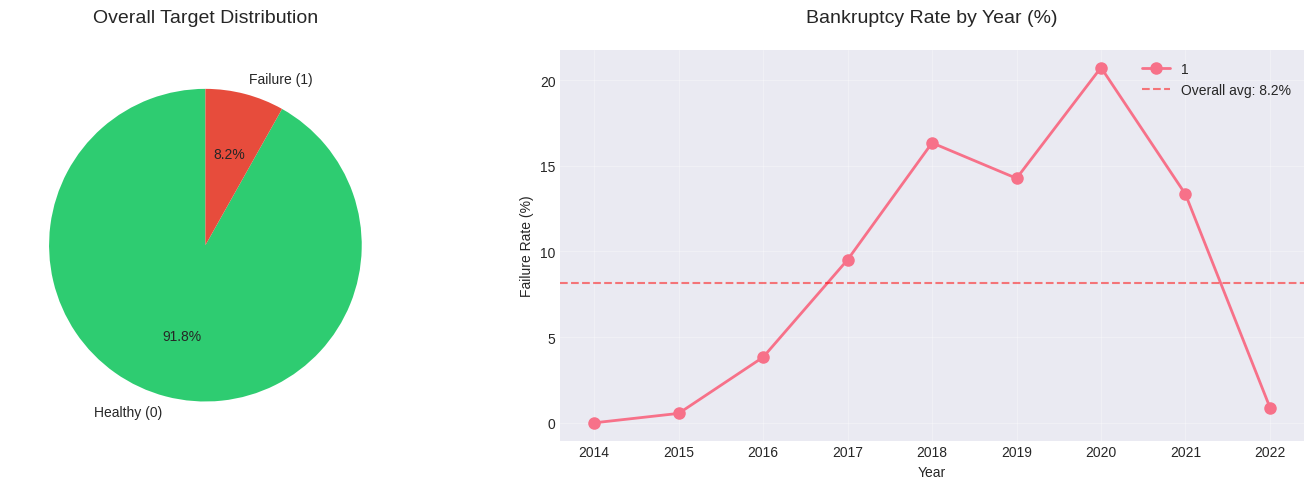


⚠️  Firms with multiple bankruptcy flags: 0


In [ ]:
#@title Target Distribution Analysis
# Overall target distribution
target_dist = df_ready['Target'].value_counts()
target_pct = df_ready['Target'].value_counts(normalize=True) * 100

print("🎯 TARGET DISTRIBUTION")
print("=" * 50)
print(f"Class 0 (Healthy): {target_dist[0]:,} ({target_pct[0]:.2f}%)")
print(f"Class 1 (Failure): {target_dist[1]:,} ({target_pct[1]:.2f}%)")
print(f"Imbalance Ratio: {target_dist[0]/target_dist[1]:.1f}:1")

# Target distribution by year
yearly_target = pd.crosstab(df_ready['Year'], df_ready['Target'], normalize='index') * 100

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
ax1.pie(target_dist.values, labels=['Healthy (0)', 'Failure (1)'],
        autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
ax1.set_title('Overall Target Distribution', fontsize=14, pad=20)

# Yearly trend
yearly_target[1].plot(kind='line', ax=ax2, marker='o', linewidth=2, markersize=8)
ax2.set_title('Bankruptcy Rate by Year (%)', fontsize=14, pad=20)
ax2.set_xlabel('Year')
ax2.set_ylabel('Failure Rate (%)')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=target_pct[1], color='red', linestyle='--', alpha=0.5, label=f'Overall avg: {target_pct[1]:.1f}%')
ax2.legend()

plt.tight_layout()
plt.show()

# Check firms with multiple bankruptcy events (data quality check)
firm_bankruptcies = df_ready.groupby('Tax code number')['Target'].sum()
multi_bankruptcy = firm_bankruptcies[firm_bankruptcies > 1]
print(f"\n⚠️  Firms with multiple bankruptcy flags: {len(multi_bankruptcy)}")
if len(multi_bankruptcy) > 0:
    print("This should be 0 according to your memo!")

📊 TEMPORAL SPLIT ANALYSIS
            Split  Samples  Firms  Failures  Failure Rate (%)
Train (2014-2018)    11376   2362       652            5.7314
     Valid (2019)     1710   1710       244           14.2690
 Test (2020-2022)     3635   1466       468           12.8748


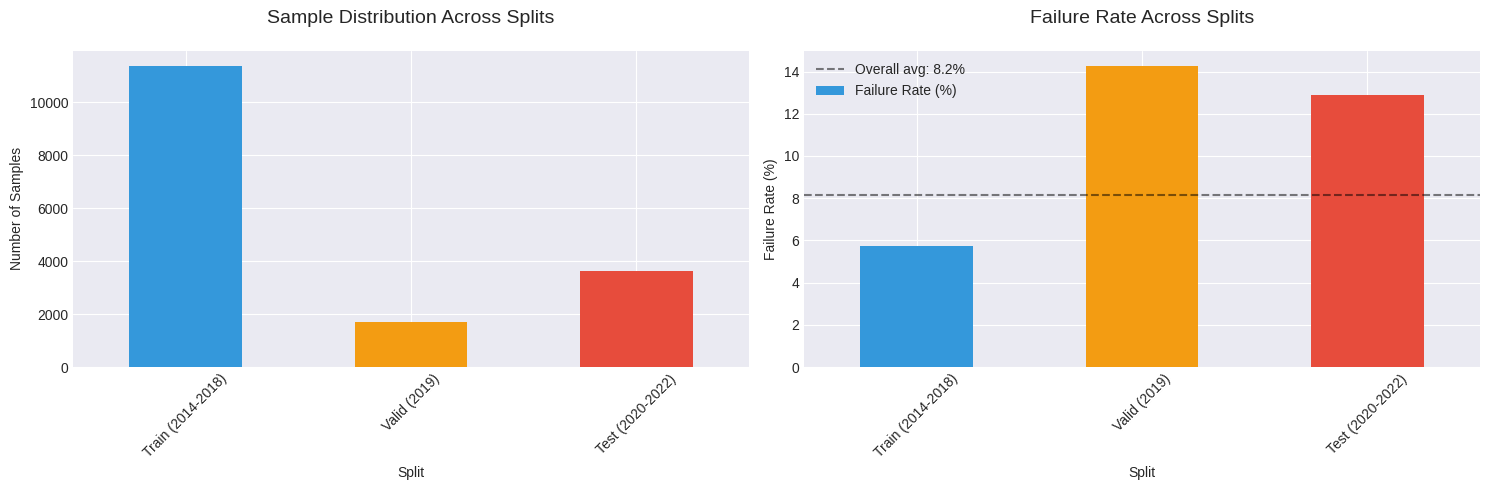


📈 Statistical Tests for Target Distribution Across Splits:


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
#@title Temporal Split Balance Analysis
# Define splits as per your memo
train_mask = df_ready['Year'].between(2014, 2018)
valid_mask = df_ready['Year'] == 2019
test_mask = df_ready['Year'].between(2020, 2022)

# Calculate target distributions for each split
splits_data = []
for split_name, mask in [('Train (2014-2018)', train_mask),
                          ('Valid (2019)', valid_mask),
                          ('Test (2020-2022)', test_mask)]:
    split_df = df_ready[mask]
    n_samples = len(split_df)
    n_failures = split_df['Target'].sum()
    failure_rate = n_failures / n_samples * 100
    n_firms = split_df['Tax code number'].nunique()

    splits_data.append({
        'Split': split_name,
        'Samples': n_samples,
        'Firms': n_firms,
        'Failures': n_failures,
        'Failure Rate (%)': failure_rate
    })

splits_df = pd.DataFrame(splits_data)

print("📊 TEMPORAL SPLIT ANALYSIS")
print("=" * 50)
print(splits_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Sample distribution
splits_df.set_index('Split')['Samples'].plot(kind='bar', ax=ax1, color=['#3498db', '#f39c12', '#e74c3c'])
ax1.set_title('Sample Distribution Across Splits', fontsize=14, pad=20)
ax1.set_ylabel('Number of Samples')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Failure rate comparison
splits_df.set_index('Split')['Failure Rate (%)'].plot(kind='bar', ax=ax2, color=['#3498db', '#f39c12', '#e74c3c'])
ax2.axhline(y=target_pct[1], color='black', linestyle='--', alpha=0.5, label=f'Overall avg: {target_pct[1]:.1f}%')
ax2.set_title('Failure Rate Across Splits', fontsize=14, pad=20)
ax2.set_ylabel('Failure Rate (%)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

# Statistical test for distribution differences
print("\n📈 Statistical Tests for Target Distribution Across Splits:")
for i, (name1, mask1) in enumerate([('Train', train_mask), ('Valid', valid_mask)]):
    for name2, mask2 in [('Valid', valid_mask), ('Test', test_mask)][i:]:
        if name1 != name2:
            rate1 = df_ready[mask1]['Target'].mean()
            rate2 = df_ready[mask2]['Target'].mean()
            # Chi-square test
            contingency = pd.crosstab(
                pd.concat([pd.Series(['Split1']*mask1.sum()), pd.Series(['Split2']*mask2.sum())]),
                pd.concat([df_ready[mask1]['Target'], df_ready[mask2]['Target']])
            )
            chi2, p_value, _, _ = stats.chi2_contingency(contingency)
            print(f"\n{name1} vs {name2}:")
            print(f"  Failure rates: {rate1:.3%} vs {rate2:.3%}")
            print(f"  Chi-square p-value: {p_value:.4f} {'⚠️ Significantly different!' if p_value < 0.05 else '✅ Not significantly different'}")

In [ ]:
#@title Feature Correlation Analysis - Preparation
# Separate features for correlation analysis
exclude_cols = ['Tax code number', 'Year', 'Target']
feature_cols = [col for col in df_ready.columns if col not in exclude_cols]

print(f"📊 Analyzing {len(feature_cols)} features for correlation...")

# Calculate correlation matrix (this might take a moment)
print("Calculating correlation matrix...")
corr_matrix = df_ready[feature_cols].corr()

# Set diagonal to NaN (don't want to count self-correlation)
np.fill_diagonal(corr_matrix.values, np.nan)

📊 Analyzing 444 features for correlation...
Calculating correlation matrix...


ValueError: could not convert string to float: 'Limited liability company - SRL'

🔍 HIGH CORRELATION ANALYSIS (threshold = 0.85)
Total feature pairs: 98,346
Highly correlated pairs: 1,409
Percentage of high correlations: 1.43%

Top 20 highest correlations:
                                                                                                               Feature 1                                                                   Feature 2  Correlation
                                                                                            0086_Invest. in parent comp.                        0087_Invest. in comp. under parent companies control       1.0000
                                             0211_Financial charges of which: from financial receivables subs and assoc.                                                   0326_Book Value per share       1.0000
0208_Inc. other than the above (of which: from subsidiaries, associated, parent cies and cies under parent cies control)                                                  0319_Market capitalisatio

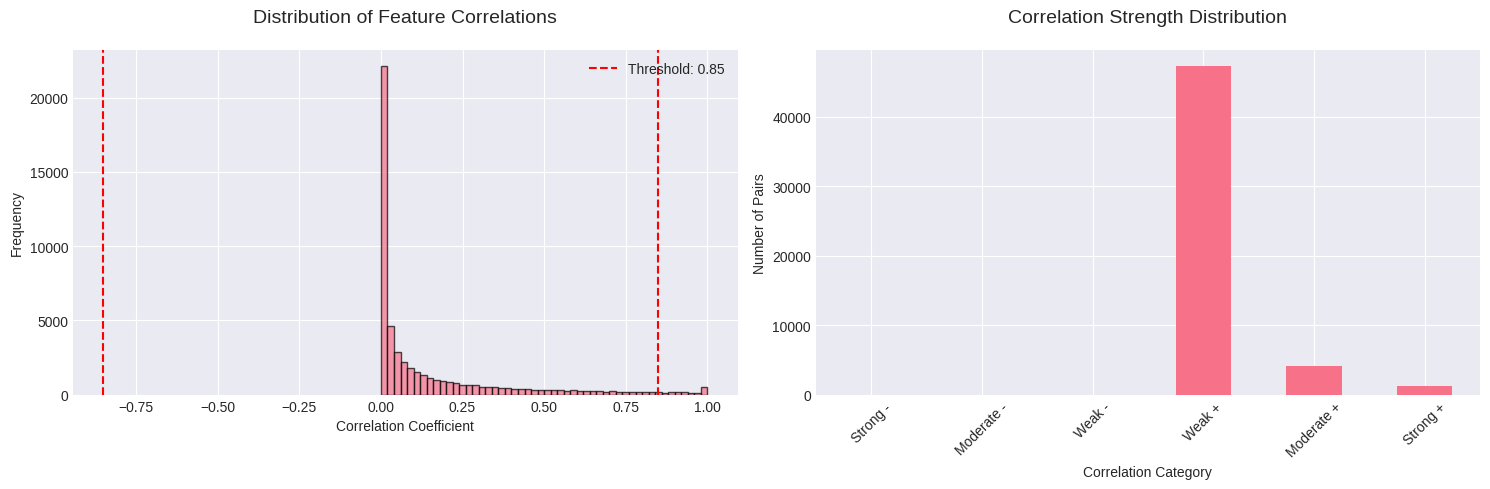

In [ ]:
#@title High Correlation Pairs Analysis
# Define correlation threshold
CORR_THRESHOLD = 0.85  # You can adjust this

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) >= CORR_THRESHOLD:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)

print(f"🔍 HIGH CORRELATION ANALYSIS (threshold = {CORR_THRESHOLD})")
print("=" * 50)
print(f"Total feature pairs: {len(feature_cols) * (len(feature_cols)-1) // 2:,}")
print(f"Highly correlated pairs: {len(high_corr_df):,}")
print(f"Percentage of high correlations: {len(high_corr_df) / (len(feature_cols) * (len(feature_cols)-1) // 2) * 100:.2f}%")

# Show top correlations
print(f"\nTop 20 highest correlations:")
print(high_corr_df.head(20).to_string(index=False))

# Correlation distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of all correlations
all_corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
ax1.hist(all_corr_values, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(x=CORR_THRESHOLD, color='red', linestyle='--', label=f'Threshold: {CORR_THRESHOLD}')
ax1.axvline(x=-CORR_THRESHOLD, color='red', linestyle='--')
ax1.set_title('Distribution of Feature Correlations', fontsize=14, pad=20)
ax1.set_xlabel('Correlation Coefficient')
ax1.set_ylabel('Frequency')
ax1.legend()

# Box plot by correlation strength
corr_categories = pd.cut(all_corr_values,
                        bins=[-1, -0.85, -0.5, 0, 0.5, 0.85, 1],
                        labels=['Strong -', 'Moderate -', 'Weak -', 'Weak +', 'Moderate +', 'Strong +'])
corr_dist = corr_categories.value_counts()
corr_dist.plot(kind='bar', ax=ax2)
ax2.set_title('Correlation Strength Distribution', fontsize=14, pad=20)
ax2.set_xlabel('Correlation Category')
ax2.set_ylabel('Number of Pairs')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#@title Feature Type Analysis
# Analyze different types of features
event_features = [col for col in feature_cols if col.startswith('ev_')]
financial_features = [col for col in feature_cols if col not in event_features]

# Check for ratios and transformations
ratio_features = [col for col in financial_features if any(marker in col.lower() for marker in ['ratio', 'per', 'margin', 'turnover', 'rate'])]
absolute_features = [col for col in financial_features if col not in ratio_features]

print("📈 FEATURE TYPE BREAKDOWN")
print("=" * 50)
print(f"Total features: {len(feature_cols)}")
print(f"Event features (ev_*): {len(event_features)}")
print(f"  - Current year: {len([f for f in event_features if not f.endswith('_lag1')])}")
print(f"  - Lagged (t-1): {len([f for f in event_features if f.endswith('_lag1')])}")
print(f"Financial features: {len(financial_features)}")
print(f"  - Ratios/rates: {len(ratio_features)}")
print(f"  - Absolute values: {len(absolute_features)}")

# Check zero variance features
zero_var_features = []
low_var_features = []
for col in feature_cols:
    var = df_loaded[col].var()
    if var == 0:
        zero_var_features.append(col)
    elif var < 0.01:
        low_var_features.append(col)

print(f"\n⚠️  Zero variance features: {len(zero_var_features)}")
if zero_var_features:
    print(f"   Examples: {zero_var_features[:5]}")
print(f"⚠️  Low variance features (var < 0.01): {len(low_var_features)}")

📈 FEATURE TYPE BREAKDOWN
Total features: 444
Event features (ev_*): 84
  - Current year: 63
  - Lagged (t-1): 21
Financial features: 360
  - Ratios/rates: 22
  - Absolute values: 338


TypeError: could not convert string to float: 'Limited liability company - SRL'

In [ ]:
#@title Recommendations for Handling Imbalance and Correlations
print("💡 RECOMMENDATIONS")
print("=" * 80)

# 1. Class Imbalance
print("\n1. CLASS IMBALANCE HANDLING:")
print(f"   Current imbalance ratio: {target_dist[0]/target_dist[1]:.1f}:1")
print("\n   Options to consider:")
print("   a) Sampling strategies:")
print("      - SMOTE (Synthetic Minority Over-sampling)")
print("      - Random undersampling of majority class")
print("      - Stratified sampling to maintain temporal patterns")
print("\n   b) Algorithm-level solutions:")
print("      - Use class_weight='balanced' in sklearn models")
print("      - For XGBoost: scale_pos_weight = (n_negative/n_positive)")
print("      - Custom loss functions that penalize false negatives more")
print("\n   c) Evaluation metrics:")
print("      - Focus on PR-AUC instead of ROC-AUC")
print("      - Use F2 score (weights recall more than precision)")
print("      - Monitor recall at fixed precision thresholds")

# 2. Feature Correlation
print("\n\n2. FEATURE CORRELATION HANDLING:")
print(f"   High correlation pairs found: {len(high_corr_df)}")
print("\n   Strategies:")
print("   a) Remove one feature from each highly correlated pair")
print("   b) Use PCA or factor analysis on correlated groups")
print("   c) Create ensemble features from correlated groups")
print("   d) Let tree-based models handle correlations naturally")
print("\n   Recommended approach for your case:")
print("   - Start with tree-based models (they handle correlations well)")
print("   - For linear models, remove features with |corr| > 0.95")
print("   - Consider domain knowledge: keep economically meaningful ratios")

# 3. Additional concerns
if len(zero_var_features) > 0:
    print(f"\n\n3. ZERO VARIANCE FEATURES:")
    print(f"   Found {len(zero_var_features)} features with zero variance")
    print("   → Remove these before modeling")

print("\n\n4. TEMPORAL CONSIDERATIONS:")
print("   - Your test set (2020-2022) includes COVID period")
print("   - Consider creating COVID indicator variable")
print("   - Monitor if model performance degrades significantly in 2020+")

print("\n\n5. DATA LEAKAGE CHECKS:")
print("   ✓ Ensure ev_bankruptcy and ev_judicial_liquidation are excluded")
print("   ✓ Consider whether other ev_* features might leak information")
print("   ✓ Verify that financial ratios are calculated correctly without future info")

💡 RECOMMENDATIONS

1. CLASS IMBALANCE HANDLING:
   Current imbalance ratio: 11.3:1

   Options to consider:
   a) Sampling strategies:
      - SMOTE (Synthetic Minority Over-sampling)
      - Random undersampling of majority class
      - Stratified sampling to maintain temporal patterns

   b) Algorithm-level solutions:
      - Use class_weight='balanced' in sklearn models
      - For XGBoost: scale_pos_weight = (n_negative/n_positive)
      - Custom loss functions that penalize false negatives more

   c) Evaluation metrics:
      - Focus on PR-AUC instead of ROC-AUC
      - Use F2 score (weights recall more than precision)
      - Monitor recall at fixed precision thresholds


2. FEATURE CORRELATION HANDLING:
   High correlation pairs found: 1409

   Strategies:
   a) Remove one feature from each highly correlated pair
   b) Use PCA or factor analysis on correlated groups
   c) Create ensemble features from correlated groups
   d) Let tree-based models handle correlations naturally


In [ ]:
#@title Quick Statistical Summary of Key Metrics
# Select a few key financial indicators to examine
sample_features = ['ev_bankruptcy', 'ev_judicial_liquidation'] + financial_features[:10]

# Compare distributions between healthy and failed firms
print("📊 SAMPLE FEATURE COMPARISON (Healthy vs Failed Firms)")
print("=" * 80)

comparison_data = []
for feature in sample_features[:12]:  # Limit to first 12 for readability
    healthy_mean = df_loaded[df_loaded['Target'] == 0][feature].mean()
    failed_mean = df_loaded[df_loaded['Target'] == 1][feature].mean()

    # T-test
    t_stat, p_value = stats.ttest_ind(
        df_loaded[df_loaded['Target'] == 0][feature].dropna(),
        df_loaded[df_loaded['Target'] == 1][feature].dropna()
    )

    comparison_data.append({
        'Feature': feature[:40],  # Truncate long names
        'Healthy Mean': healthy_mean,
        'Failed Mean': failed_mean,
        'Difference': failed_mean - healthy_mean,
        'P-value': p_value,
        'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format='%.4f'))
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")

📊 SAMPLE FEATURE COMPARISON (Healthy vs Failed Firms)


TypeError: Could not convert string 'Limited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person joint stock company - SPAOne-person joint stock company - SPAOne-person joint stock company - SPAOne-person joint stock company - SPAOne-person joint stock company - SPAOne-person joint stock company - SPAOne-person joint stock company - SPAOne-person joint stock company - SPAOne-person joint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPASocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability - SCARLCooperative company with limited liability - SCARLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited partnership - SASLimited partnership - SASLimited partnership - SASOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySocial cooperative companySocial cooperative companySocial cooperative companyOne-person company with limited liability - SRLOne-person company with limited liability - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSocial cooperative companySocial cooperative companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLFoundationFoundationFoundationFoundationFoundationFoundationFoundationFoundationFoundationLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySpecial agency as per law 142/90Special agency as per law 142/90Special agency as per law 142/90Special agency as per law 142/90Special agency as per law 142/90Special agency as per law 142/90Special agency as per law 142/90Special agency as per law 142/90Special agency as per law 142/90Simplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSocial cooperative companySocial cooperative companySocial cooperative companySocial cooperative companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSocial cooperative companySocial cooperative companySocial cooperative companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability consortiumLimited liability consortiumLimited liability consortiumOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPACooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyJoint stock company - SPAJoint stock company - SPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLConsortiumConsortiumConsortiumConsortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited partnership - SASLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyJoint stock company - SPAJoint stock company - SPAJoint stock company - SPAJoint stock company - SPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLOne-person company with limited liability - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAConsortiumConsortiumConsortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability - SCARLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPAConsortiumConsortiumConsortiumConsortiumConsortiumConsortiumLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPASimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLSimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companySimplified limited liability companyLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumLimited liability consortiumCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPALimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLLimited liability company - SRLCooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPACooperative company with limited liability by shares - SCARLPA' to numeric

In [ ]:
#@title Class Imbalance Strategy Comparison

print("🎯 CLASS IMBALANCE STRATEGIES")
print("=" * 50)
print(f"Current ratio: {(df_ready['Target'] == 0).sum()} healthy : {(df_ready['Target'] == 1).sum()} failures")
print(f"Imbalance: {(df_ready['Target'] == 0).sum() / (df_ready['Target'] == 1).sum():.1f}:1")

print("\n📊 OPTION 1: Random Undersampling")
print("  Pros: Simple, ensures balanced dataset")
print("  Cons: Loses 90% of your data!, might miss rare patterns")
print(f"  Result: ~2,728 samples total (1,364 each class)")

print("\n📊 OPTION 2: Class Weights (Recommended)")
print("  Pros: Uses ALL data, no information loss")
print("  Cons: None really - standard practice")
print("  Implementation:")
print(f"    - Logistic/Linear: class_weight='balanced'")
print(f"    - XGBoost: scale_pos_weight={((df_ready['Target'] == 0).sum() / (df_ready['Target'] == 1).sum()):.1f}")
print(f"    - LightGBM: is_unbalance=True")

print("\n📊 OPTION 3: SMOTE (Synthetic Minority Oversampling)")
print("  Pros: Creates synthetic failures, more training data")
print("  Cons: Can overfit, synthetic data may not be realistic")
print("  Result: ~30,714 samples (balanced)")

print("\n📊 OPTION 4: Temporal-Aware Undersampling")
print("  Pros: Maintains temporal patterns while balancing")
print("  Cons: Still loses data, but less than random")
print("  Method: Keep all failures, sample healthy firms proportionally by year")

# My recommendation
print("\n💡 RECOMMENDED APPROACH:")
print("1. Primary: Use class weights (Option 2)")
print("2. For comparison: Try temporal-aware undersampling")
print("3. Avoid: Random undersampling (too much data loss)")

🎯 CLASS IMBALANCE STRATEGIES
Current ratio: 15357 healthy : 1364 failures
Imbalance: 11.3:1

📊 OPTION 1: Random Undersampling
  Pros: Simple, ensures balanced dataset
  Cons: Loses 90% of your data!, might miss rare patterns
  Result: ~2,728 samples total (1,364 each class)

📊 OPTION 2: Class Weights (Recommended)
  Pros: Uses ALL data, no information loss
  Cons: None really - standard practice
  Implementation:
    - Logistic/Linear: class_weight='balanced'
    - XGBoost: scale_pos_weight=11.3
    - LightGBM: is_unbalance=True

📊 OPTION 3: SMOTE (Synthetic Minority Oversampling)
  Pros: Creates synthetic failures, more training data
  Cons: Can overfit, synthetic data may not be realistic
  Result: ~30,714 samples (balanced)

📊 OPTION 4: Temporal-Aware Undersampling
  Pros: Maintains temporal patterns while balancing
  Cons: Still loses data, but less than random
  Method: Keep all failures, sample healthy firms proportionally by year

💡 RECOMMENDED APPROACH:
1. Primary: Use class we

In [ ]:
#@title Detailed Correlation Group Analysis
# Using the high_corr_df from before
if 'high_corr_df' in locals():
    # Group correlations by feature type
    investment_corr = high_corr_df[
        high_corr_df['Feature 1'].str.contains('Invest|invest', na=False) |
        high_corr_df['Feature 2'].str.contains('Invest|invest', na=False)
    ]

    financial_corr = high_corr_df[
        high_corr_df['Feature 1'].str.contains('Financial|financial', na=False) |
        high_corr_df['Feature 2'].str.contains('Financial|financial', na=False)
    ]

    price_corr = high_corr_df[
        high_corr_df['Feature 1'].str.contains('price|Price', na=False) |
        high_corr_df['Feature 2'].str.contains('price|Price', na=False)
    ]

    print("🔍 CORRELATION PATTERNS:")
    print(f"\nInvestment-related: {len(investment_corr)} pairs")
    print(f"Financial charges: {len(financial_corr)} pairs")
    print(f"Price-related: {len(price_corr)} pairs")

    # Features to potentially drop
    features_to_drop = set()

    # From each perfectly correlated pair, keep one
    for _, row in high_corr_df[high_corr_df['Correlation'] == 1.0].iterrows():
        # Keep the shorter-named feature (usually more general)
        if len(row['Feature 1']) > len(row['Feature 2']):
            features_to_drop.add(row['Feature 1'])
        else:
            features_to_drop.add(row['Feature 2'])

    print(f"\n🗑️ Recommend dropping {len(features_to_drop)} perfectly correlated features")

🔍 CORRELATION PATTERNS:

Investment-related: 55 pairs
Financial charges: 157 pairs
Price-related: 406 pairs

🗑️ Recommend dropping 28 perfectly correlated features


In [ ]:
#@title Summary of Data Issues and Perfect Correlations Analysis

print("📊 DATA QUALITY SUMMARY")
print("=" * 80)

# 1. String Variables Found
print("\n1. STRING VARIABLES:")
print("   • Legal form: 13 categories (mostly SRL companies)")
print("   • Company category: Only 1 value ('Limited company') - can be dropped")
print("   • Financial ratios (0007-0014): Were incorrectly typed as strings!")
print("   • Accounting model: 3 types (Abbreviated, Detailed)")
print("   → Action: Encode Legal form & Accounting model; Fix ratio columns")

# 2. Class Imbalance
print("\n2. CLASS IMBALANCE:")
print("   • 11.3:1 ratio (91.8% healthy vs 8.2% failures)")
print("   → Decision: Use class weights in all models")

# 3. Temporal Issues
print("\n3. TEMPORAL DISTRIBUTION:")
print("   • Train (2014-2018): 5.7% failure rate")
print("   • Valid (2019): 14.3% failure rate (2.5x increase!)")
print("   • Test (2020-2022): 12.9% failure rate")
print("   → COVID impact clearly visible in 2020")

# 4. Perfect Correlations
print("\n4. PERFECT CORRELATIONS: 28 feature pairs")
print("   • Investment-related: Parent/subsidiary investments")
print("   • Financial charges: Multiple identical calculations")
print("   • Monthly prices: Many months have identical values")

📊 DATA QUALITY SUMMARY

1. STRING VARIABLES:
   • Legal form: 13 categories (mostly SRL companies)
   • Company category: Only 1 value ('Limited company') - can be dropped
   • Financial ratios (0007-0014): Were incorrectly typed as strings!
   • Accounting model: 3 types (Abbreviated, Detailed)
   → Action: Encode Legal form & Accounting model; Fix ratio columns

2. CLASS IMBALANCE:
   • 11.3:1 ratio (91.8% healthy vs 8.2% failures)
   → Decision: Use class weights in all models

3. TEMPORAL DISTRIBUTION:
   • Train (2014-2018): 5.7% failure rate
   • Valid (2019): 14.3% failure rate (2.5x increase!)
   • Test (2020-2022): 12.9% failure rate
   → COVID impact clearly visible in 2020

4. PERFECT CORRELATIONS: 28 feature pairs
   • Investment-related: Parent/subsidiary investments
   • Financial charges: Multiple identical calculations
   • Monthly prices: Many months have identical values


In [ ]:
#@title Show Perfect Correlation Examples

# Let's examine the perfectly correlated features
perfect_corr_pairs = high_corr_df[high_corr_df['Correlation'].abs() == 1.0].copy()

print("🔍 PERFECT CORRELATION EXAMPLES")
print("=" * 80)
print(f"Total perfectly correlated pairs: {len(perfect_corr_pairs)}")

# Group by correlation patterns
print("\n📈 CORRELATION PATTERNS:")

# Pattern 1: Investment features
inv_pairs = perfect_corr_pairs[
    perfect_corr_pairs['Feature 1'].str.contains('Invest', na=False) |
    perfect_corr_pairs['Feature 2'].str.contains('Invest', na=False)
]
if len(inv_pairs) > 0:
    print(f"\n1. INVESTMENT FEATURES ({len(inv_pairs)} pairs):")
    print(inv_pairs[['Feature 1', 'Feature 2']].head(3).to_string(index=False))

# Pattern 2: Price features
price_pairs = perfect_corr_pairs[
    perfect_corr_pairs['Feature 1'].str.contains('price', na=False) |
    perfect_corr_pairs['Feature 2'].str.contains('price', na=False)
]
if len(price_pairs) > 0:
    print(f"\n2. MONTHLY PRICE FEATURES ({len(price_pairs)} pairs):")
    print(price_pairs[['Feature 1', 'Feature 2']].head(3).to_string(index=False))

# Pattern 3: Financial features
fin_pairs = perfect_corr_pairs[
    perfect_corr_pairs['Feature 1'].str.contains('Financial|financial', na=False) |
    perfect_corr_pairs['Feature 2'].str.contains('Financial|financial', na=False)
]
if len(fin_pairs) > 0:
    print(f"\n3. FINANCIAL FEATURES ({len(fin_pairs)} pairs):")
    print(fin_pairs[['Feature 1', 'Feature 2']].head(3).to_string(index=False))

🔍 PERFECT CORRELATION EXAMPLES
Total perfectly correlated pairs: 143

📈 CORRELATION PATTERNS:

2. MONTHLY PRICE FEATURES (25 pairs):
                                                                  Feature 1                          Feature 2
0211_Financial charges of which: from financial receivables subs and assoc.   0335_Monthly - High price - June
0211_Financial charges of which: from financial receivables subs and assoc. 0351_Monthly - Low price - October
0211_Financial charges of which: from financial receivables subs and assoc.   0345_Monthly - Low price - April

3. FINANCIAL FEATURES (30 pairs):
                                                                  Feature 1                                Feature 2
                              0251_Non-fixed financial assets: (investment)                 0295_of which restricted
0211_Financial charges of which: from financial receivables subs and assoc.         0335_Monthly - High price - June
0211_Financial charges of which: from

In [ ]:
#@title Examine Actual Values of Perfectly Correlated Features

# Let's look at actual data to understand WHY they're perfectly correlated
print("🔬 EXAMINING PERFECTLY CORRELATED FEATURE VALUES")
print("=" * 80)

# Take first 5 perfectly correlated pairs
for i, row in perfect_corr_pairs.head(5).iterrows():
    feat1, feat2 = row['Feature 1'], row['Feature 2']

    print(f"\n📊 Pair {i+1}: Perfect correlation")
    print(f"Feature 1: {feat1[:60]}...")
    print(f"Feature 2: {feat2[:60]}...")

    # Show sample values
    sample_data = df_ready_clean[[feat1, feat2]].dropna()

    # Check if they're identical
    are_identical = (sample_data[feat1] == sample_data[feat2]).all()

    if are_identical:
        print("→ These features are IDENTICAL!")
        print(f"  Non-zero values: {(sample_data[feat1] != 0).sum()}")
        print(f"  Unique values: {sample_data[feat1].nunique()}")
    else:
        print("→ Perfect linear relationship (not identical)")
        # Show correlation details
        print(f"  Sample values:")
        print(sample_data.head(3).to_string())

🔬 EXAMINING PERFECTLY CORRELATED FEATURE VALUES

📊 Pair 1408: Perfect correlation
Feature 1: ev_extraordinary_administration_ever...
Feature 2: ev_state_of_insolvency_ever...
→ These features are IDENTICAL!
  Non-zero values: 1
  Unique values: 2

📊 Pair 1406: Perfect correlation
Feature 1: ev_cessation_of_any_business_lag1...
Feature 2: ev_cessation_of_any_business_ever...
→ These features are IDENTICAL!
  Non-zero values: 1
  Unique values: 2

📊 Pair 1113: Perfect correlation
Feature 1: 0286_(Dividends and interim dividends paid)...
Feature 2: 0293_Cheques...
→ Perfect linear relationship (not identical)
  Sample values:
       0286_(Dividends and interim dividends paid)  0293_Cheques
10423                                    -235.0000        0.1730
16000                                       0.0010        0.2850

📊 Pair 1107: Perfect correlation
Feature 1: 0282_(Loans repayment)...
Feature 2: ev_court_ordered_administration...
→ Perfect linear relationship (not identical)
  Sample va

In [ ]:
#@title Financial Ratio Columns Issue

# The financial ratios being stored as strings is concerning
print("⚠️ CRITICAL ISSUE: Financial Ratios as Strings")
print("=" * 80)

ratio_cols = ['0007_EBITDA/Vendite', '0008_Return on sales (ROS)',
              '0009_Return on asset (ROA)', '0010_Return on equity (ROE)',
              '0011_Debt/equity ratio', '0012_Banks/turnover',
              '0013_Debt/EBITDA ratio', '0014_Total assets turnover (times)']

print("These should be numeric but are stored as strings:")
for col in ratio_cols:
    if col in df_ready.columns:
        # Sample some values
        sample_vals = df_ready[col].dropna().head(5).tolist()
        print(f"\n{col}:")
        print(f"  Sample values: {sample_vals}")
        print(f"  Unique count: {df_ready[col].nunique()}")

print("\n🔧 FIX REQUIRED: Convert these to numeric!")

⚠️ CRITICAL ISSUE: Financial Ratios as Strings
These should be numeric but are stored as strings:

0007_EBITDA/Vendite:
  Sample values: [12.17, 14.81, 9.59, 11.2, 12.84]
  Unique count: 4104

0008_Return on sales (ROS):
  Sample values: [5.75, 9.53, 3.76, 4.2, 5.56]
  Unique count: 3214

0009_Return on asset (ROA):
  Sample values: [2.38, 3.82, 1.34, 1.31, 1.82]
  Unique count: 4223

0010_Return on equity (ROE):
  Sample values: [2.06, 2.11, 1.5, 2.41, 3.09]
  Unique count: 5756

0011_Debt/equity ratio:
  Sample values: [0.47, 0.58, 0.49, 0.6, 0.4]
  Unique count: 1393

0012_Banks/turnover:
  Sample values: [56.61, 70.36, 73.38, 74.49, 51.34]
  Unique count: 3104

0013_Debt/EBITDA ratio:
  Sample values: [4.65, 4.75, 7.65, 6.65, 4.0]
  Unique count: 1852

0014_Total assets turnover (times):
  Sample values: [0.37, 0.36, 0.32, 0.26, 0.27]
  Unique count: 479

🔧 FIX REQUIRED: Convert these to numeric!


In [ ]:
#@title Financial Ratio Columns Issue

# The financial ratios being stored as strings is concerning
print("⚠️ CRITICAL ISSUE: Financial Ratios as Strings")
print("=" * 80)

ratio_cols = ['0007_EBITDA/Vendite', '0008_Return on sales (ROS)',
              '0009_Return on asset (ROA)', '0010_Return on equity (ROE)',
              '0011_Debt/equity ratio', '0012_Banks/turnover',
              '0013_Debt/EBITDA ratio', '0014_Total assets turnover (times)']

print("These should be numeric but are stored as strings:")
for col in ratio_cols:
    if col in df_ready.columns:
        # Sample some values
        sample_vals = df_ready[col].dropna().head(5).tolist()
        print(f"\n{col}:")
        print(f"  Sample values: {sample_vals}")
        print(f"  Unique count: {df_ready[col].nunique()}")

print("\n🔧 FIX REQUIRED: Convert these to numeric!")

⚠️ CRITICAL ISSUE: Financial Ratios as Strings
These should be numeric but are stored as strings:

0007_EBITDA/Vendite:
  Sample values: [12.17, 14.81, 9.59, 11.2, 12.84]
  Unique count: 4104

0008_Return on sales (ROS):
  Sample values: [5.75, 9.53, 3.76, 4.2, 5.56]
  Unique count: 3214

0009_Return on asset (ROA):
  Sample values: [2.38, 3.82, 1.34, 1.31, 1.82]
  Unique count: 4223

0010_Return on equity (ROE):
  Sample values: [2.06, 2.11, 1.5, 2.41, 3.09]
  Unique count: 5756

0011_Debt/equity ratio:
  Sample values: [0.47, 0.58, 0.49, 0.6, 0.4]
  Unique count: 1393

0012_Banks/turnover:
  Sample values: [56.61, 70.36, 73.38, 74.49, 51.34]
  Unique count: 3104

0013_Debt/EBITDA ratio:
  Sample values: [4.65, 4.75, 7.65, 6.65, 4.0]
  Unique count: 1852

0014_Total assets turnover (times):
  Sample values: [0.37, 0.36, 0.32, 0.26, 0.27]
  Unique count: 479

🔧 FIX REQUIRED: Convert these to numeric!
